In [3]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ff_energy.ffe.utils import read_from_pickle
import jax.numpy as jnp
from ff_energy.ffe.plot import plot_energy_MSE, plot_ff_fit
from ff_energy.ffe.structure import atom_key_pairs
from ff_energy.ffe.potential import LJ, akp_indx
from ff_energy.ffe.ff import FF
from ff_energy.ffe.ff_fit import LJ_bound, load_ff, fit_func, fit_repeat
from ff_energy.ffe.data import pairs_data
from ff_energy.ffe.utils import pickle_output, read_from_pickle, str2int
from ff_energy.ffe.utils import pickle_output, PKL_PATH, read_from_pickle, str2int
from ff_energy.ffe.data import pairs_data, Data

In [4]:
p = PKL_PATH / "water_cluster/pbe0dz/pbe.pc"
data_tip3 = Data(p)

loading pickles from  /home/boittier/Documents/phd/ff_energy/pickles/water_cluster/pbe0dz/pbe.pc


In [5]:
sig_bound = (0.001, 2.5)
ep_bound = (0.001, 2.5)
chg_bound = (100,2000)

CHGPEN_bound = [(chg_bound),(chg_bound),(chg_bound),(chg_bound),(0,2000)]
LJ_bound = ((sig_bound), (sig_bound), (ep_bound), (ep_bound))
DE_bound = ((sig_bound), (sig_bound), (ep_bound), (ep_bound), 
            (1, 8), (6, 20))

In [6]:
#  example
# ffpkl = "ECOL_pbe0dz_FOE.ff.pkl"
ffpkl = "kmdcm_pbe0dz_clusters.ff.pkl"

In [7]:
_c = next(read_from_pickle(f"ff/{ffpkl}"))
_c

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


FF: LJ water_cluster ELEC harmonic intE (jax_coloumb: True)

In [8]:
# _c.data["ELEC"] = data_tip3.data["ELEC"]

In [9]:
_c.intE = "ECOL"
_c.set_targets()
_c

FF: LJ water_cluster ELEC harmonic ECOL (jax_coloumb: True)

In [10]:
fit_repeat(_c, 
           1, 
           f"{ffpkl}_chgpen",
           bounds = CHGPEN_bound,
           loss="chgpen",
           # quiet='true'
          )

Optimizing LJ parameters...
function: get_loss_chgpen
bounds: [(100, 2000), (100, 2000), (100, 2000), (100, 2000), (0, 2000)]
maxfev: 10000
initial guess: [880.853144851502, 1916.8287812889835, 1697.4726291364711, 1836.412840702067, 1631.0079232261796]


/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:179: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


final_loss_fn:  134.36634826660156
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 134.36634826660156
             x: [ 9.765e+02  1.927e+03  2.000e+03  1.946e+03  2.638e+02]
           nit: 123
          nfev: 312
 final_simplex: (array([[ 9.765e+02,  1.927e+03, ...,  1.946e+03,
                         2.638e+02],
                       [ 9.765e+02,  1.927e+03, ...,  1.946e+03,
                         2.638e+02],
                       ...,
                       [ 9.765e+02,  1.927e+03, ...,  1.946e+03,
                         2.638e+02],
                       [ 9.765e+02,  1.927e+03, ...,  1.946e+03,
                         2.638e+02]]), array([ 1.344e+02,  1.344e+02,  1.344e+02,  1.344e+02,
                        1.344e+02,  1.344e+02]))


In [11]:
resx = _c.opt_parm 
loss = _c.get_loss_chgpen(resx)
loss
resx

array([ 976.4710026 , 1927.4526069 , 2000.        , 1946.08921034,
        263.82453723])

In [12]:
np.sqrt(loss)

11.59165

In [13]:
# _c.eval_jax_chgpen(resx ) 

5.2106237007694204e-185


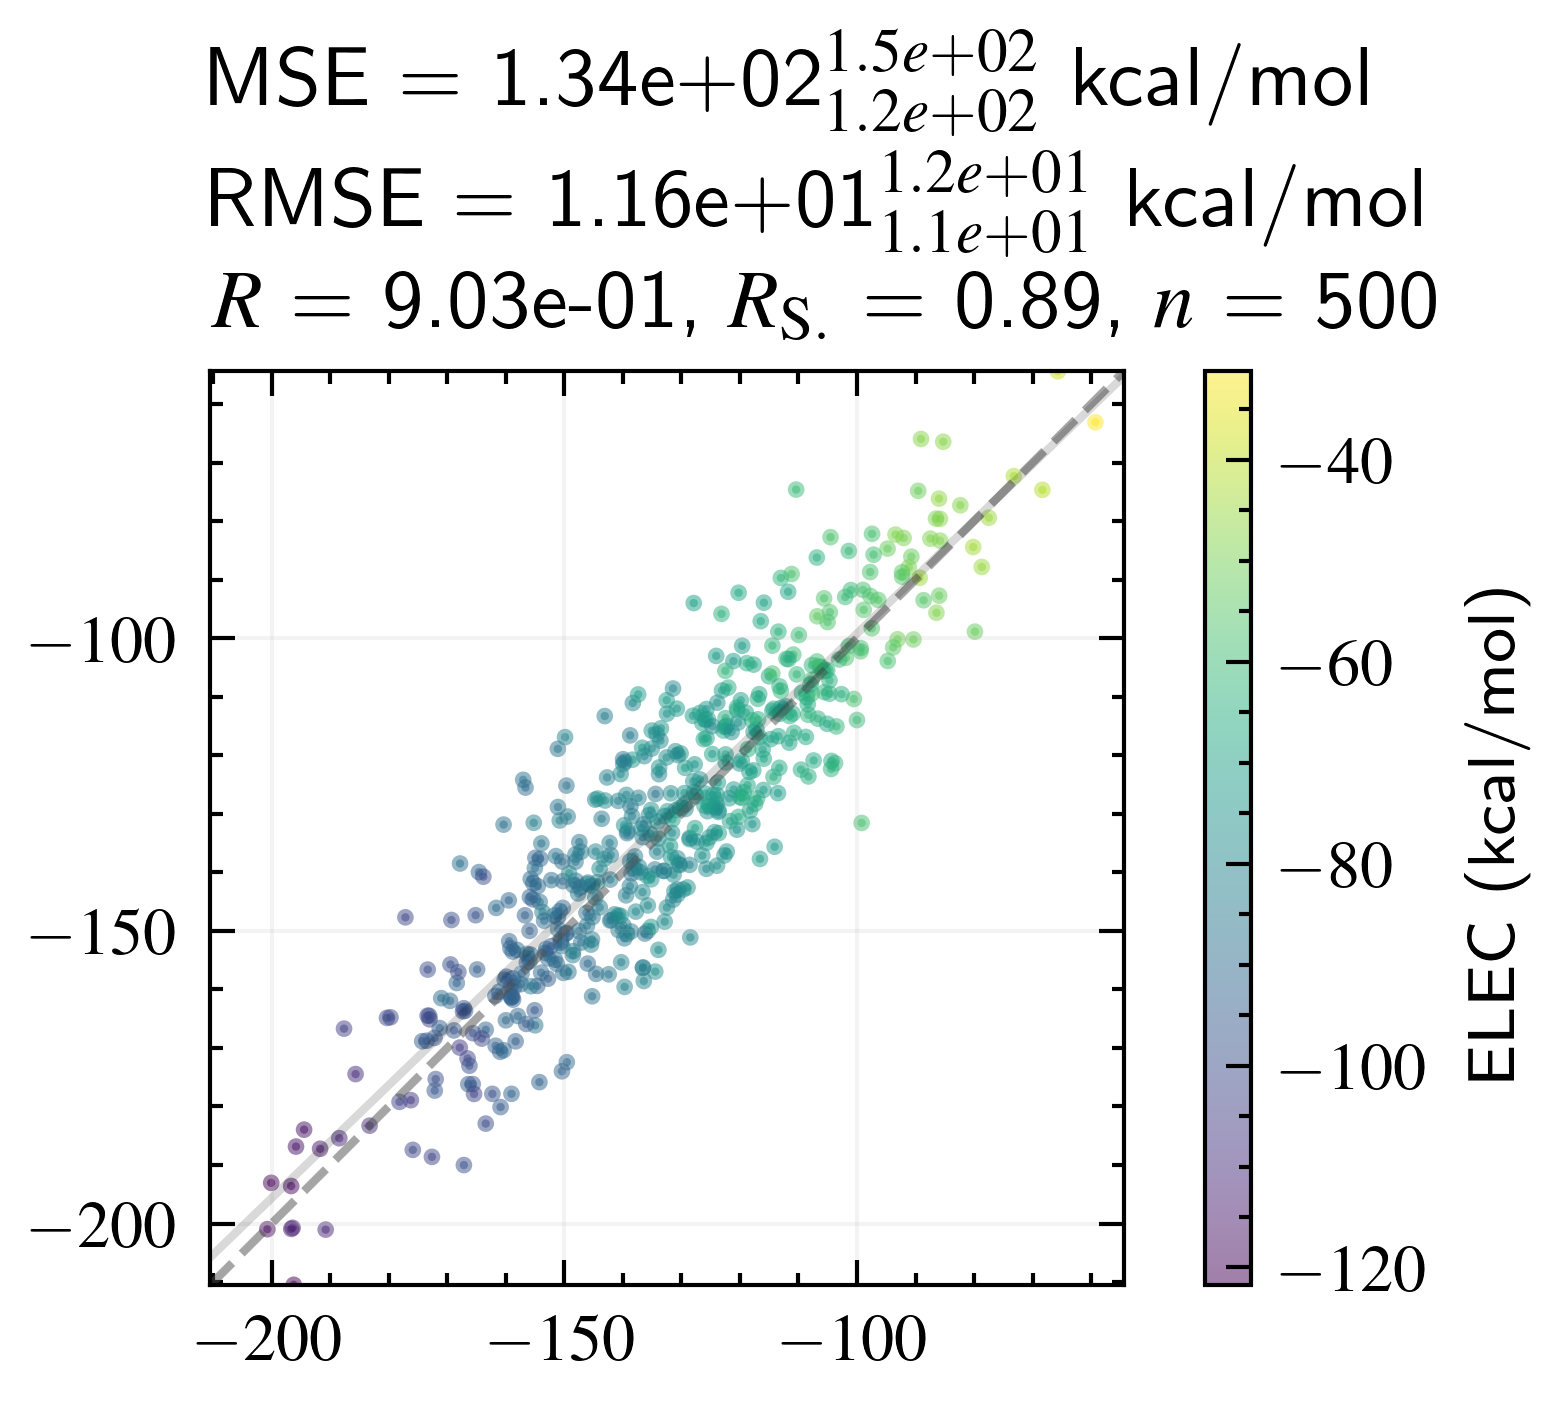

In [14]:
# _c.eval_jax_chgpen(resx ) 
_c.data["fit_ECOL"] = _c.eval_jax_chgpen(resx ) + _c.data.ELEC

plot_energy_MSE(_c.data, "ECOL", "fit_ECOL",  elec = "ELEC")

plt.savefig("kmdcm_fit_ecol.pdf")

0.0


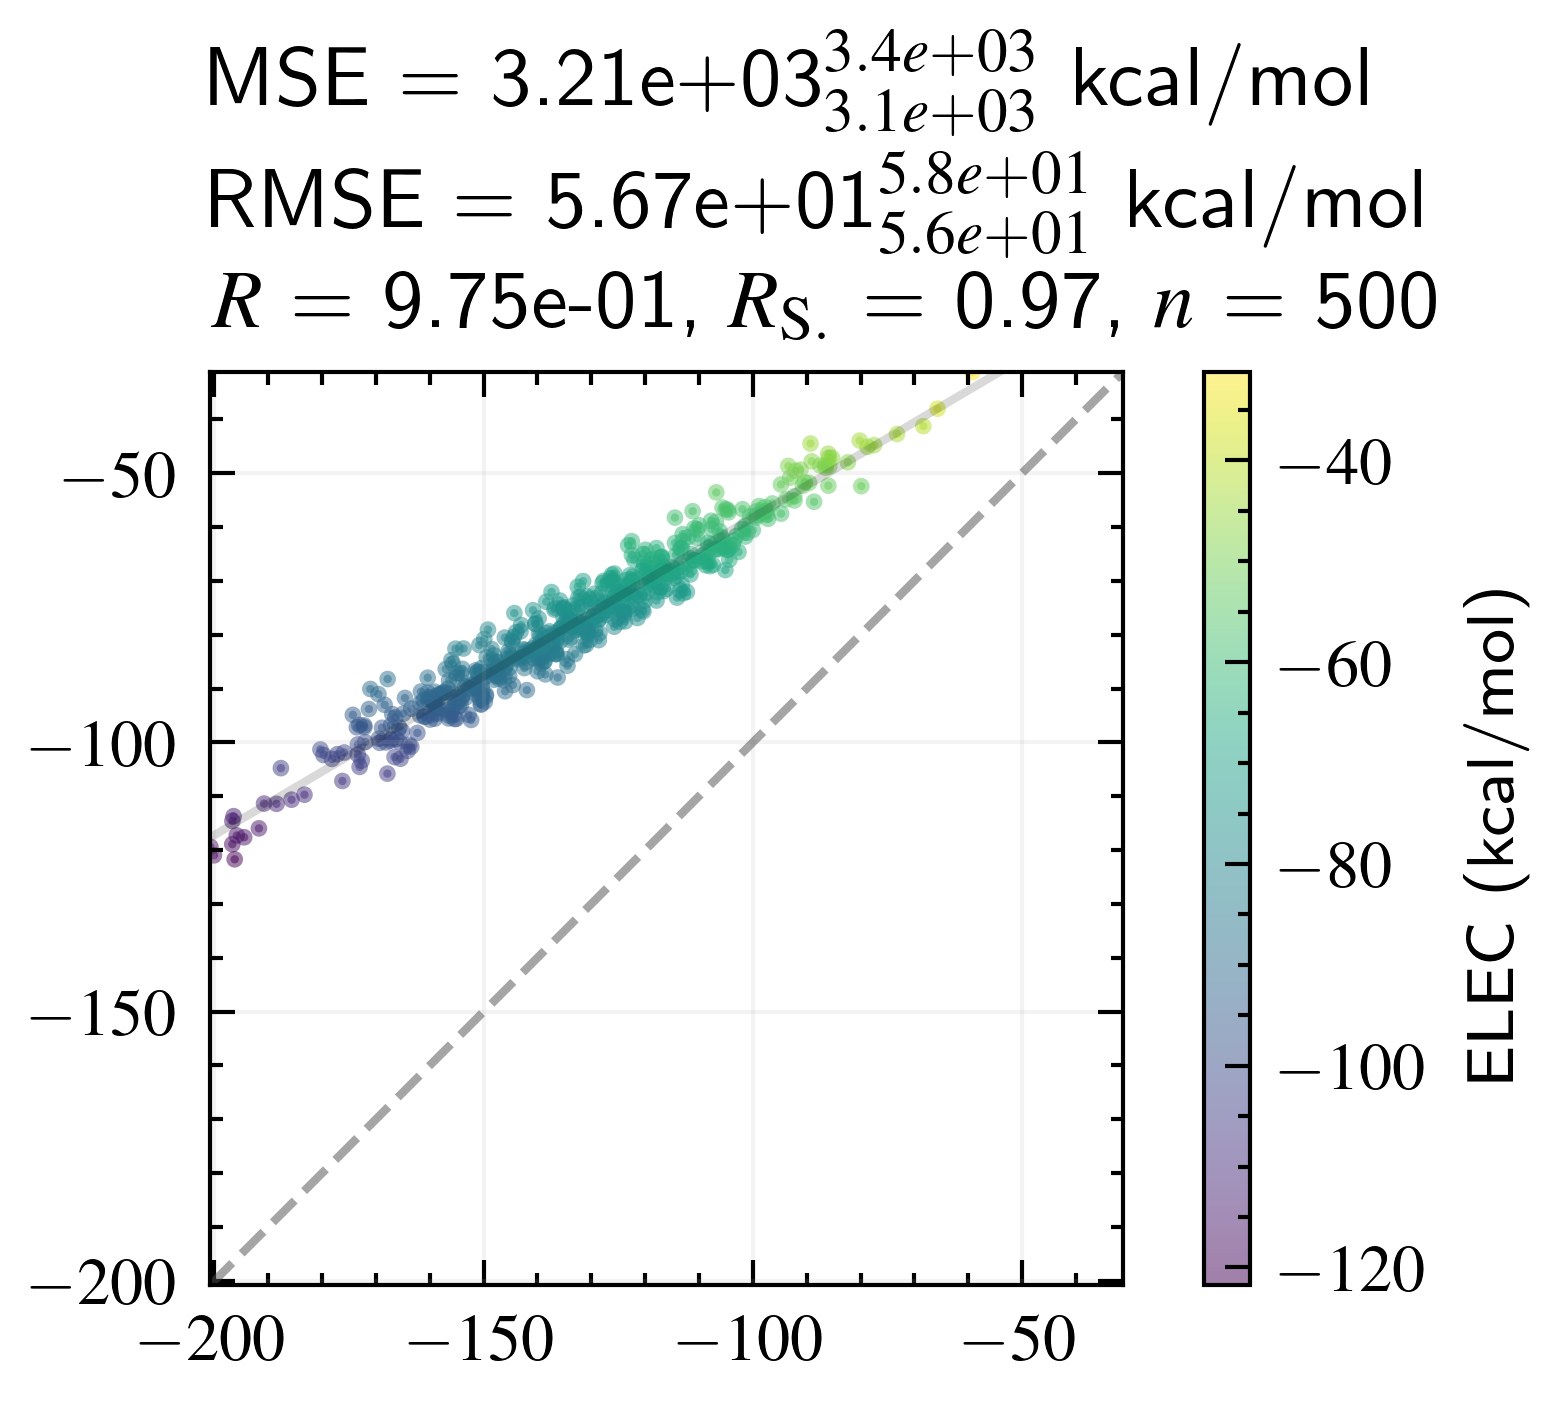

In [15]:
plot_energy_MSE(_c.data, "ECOL", "ELEC",  elec = "ELEC")
plt.savefig("kmdcm_ecol.pdf")

In [16]:
_c.data["fit_ECOL"].mean()

-131.82846

In [17]:
pickle_output(_c, "ff/fit_ECOL_kmdcm_intE")

#  LJ fit


In [18]:
# _c = next(read_from_pickle(f"ff/{ffpkl}"))
LJFF = next(read_from_pickle(f"ff/fit_ECOL_kmdcm_intE.pkl"))

In [19]:
LJFF.elec = "ELEC"
LJFF.intE = "intE"
LJFF.set_intE()
LJFF.set_targets()
print(LJFF.targets.mean())
LJFF

19.06506


FF: LJ water_cluster ELEC harmonic intE (jax_coloumb: True)

In [20]:
fit_repeat(LJFF, 
           15, 
           f"{ffpkl}_LJ",
           bounds = LJ_bound,
           loss="jax",
           quiet='true'
          )

/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:179: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


In [21]:
pd.DataFrame(LJFF.opt_results).sort_values("fun")

,fun,nit,nfev,status,success,message,x,final_simplex
7,16.195114,385,685,0,True,Optimization terminated successfully.,"[0.001, 1.8075449678683502, 0.2342334456853799...","([[0.001, 1.8075449678683502, 0.23423344568537..."
2,20.635584,91,182,0,True,Optimization terminated successfully.,"[0.001, 2.37682358759135, 2.5, 0.001]","([[0.001, 2.37682358759135, 2.5, 0.001], [0.00..."
9,21.945210,680,1187,0,True,Optimization terminated successfully.,"[1.5683227388679306, 1.7245826768708499, 0.001...","([[1.5683227388679306, 1.7245826768708499, 0.0..."
15,30.692957,304,549,0,True,Optimization terminated successfully.,"[1.6992994210533365, 0.7577646404670293, 0.001...","([[1.6992994210533365, 0.7577646404670293, 0.0..."
4,103.624413,126,248,0,True,Optimization terminated successfully.,"[1.863996680384731, 0.001, 0.001, 0.001]","([[1.863996680384731, 0.001, 0.001, 0.001], [1..."
0,134.366913,132,323,0,True,Optimization terminated successfully.,"[1496.1463249145506, 1437.977921449105, 1528.3...","([[1496.1463249145506, 1437.977921449105, 1528..."
3,418.809387,46,154,0,True,Optimization terminated successfully.,"[0.001, 0.029737538352729187, 0.83994214148901...","([[0.001, 0.029737538352729187, 0.839942141489..."
5,418.809387,40,137,0,True,Optimization terminated successfully.,"[0.001, 0.0630635932327347, 2.485934411934334,...","([[0.001, 0.0630635932327347, 2.48593441193433..."
6,418.809387,37,126,0,True,Optimization terminated successfully.,"[0.001, 0.06572866782652684, 0.389662713871651...","([[0.001, 0.06572866782652684, 0.3896627138716..."
8,418.809387,44,152,0,True,Optimization terminated successfully.,"[0.001, 0.04996762805236199, 1.726869319806821...","([[0.001, 0.04996762805236199, 1.7268693198068..."


In [22]:
bestres = list(pd.DataFrame(\
                  LJFF.opt_results)\
     .sort_values("fun").x)[0]
bestres

array([1.00000000e-03, 1.80754497e+00, 2.34233446e-01, 1.25002012e-01])

In [23]:
abs(LJFF.eval_jax(bestres)).mean()

Array(19.0571, dtype=float32)

In [24]:
abs(LJFF.targets).mean()

Array(19.06541, dtype=float32)

In [25]:
best = list(pd.DataFrame(\
                  LJFF.opt_results)\
     .sort_values("fun").fun)[0]
np.sqrt(best)

4.024315362361924

2.6835648048822207e-274


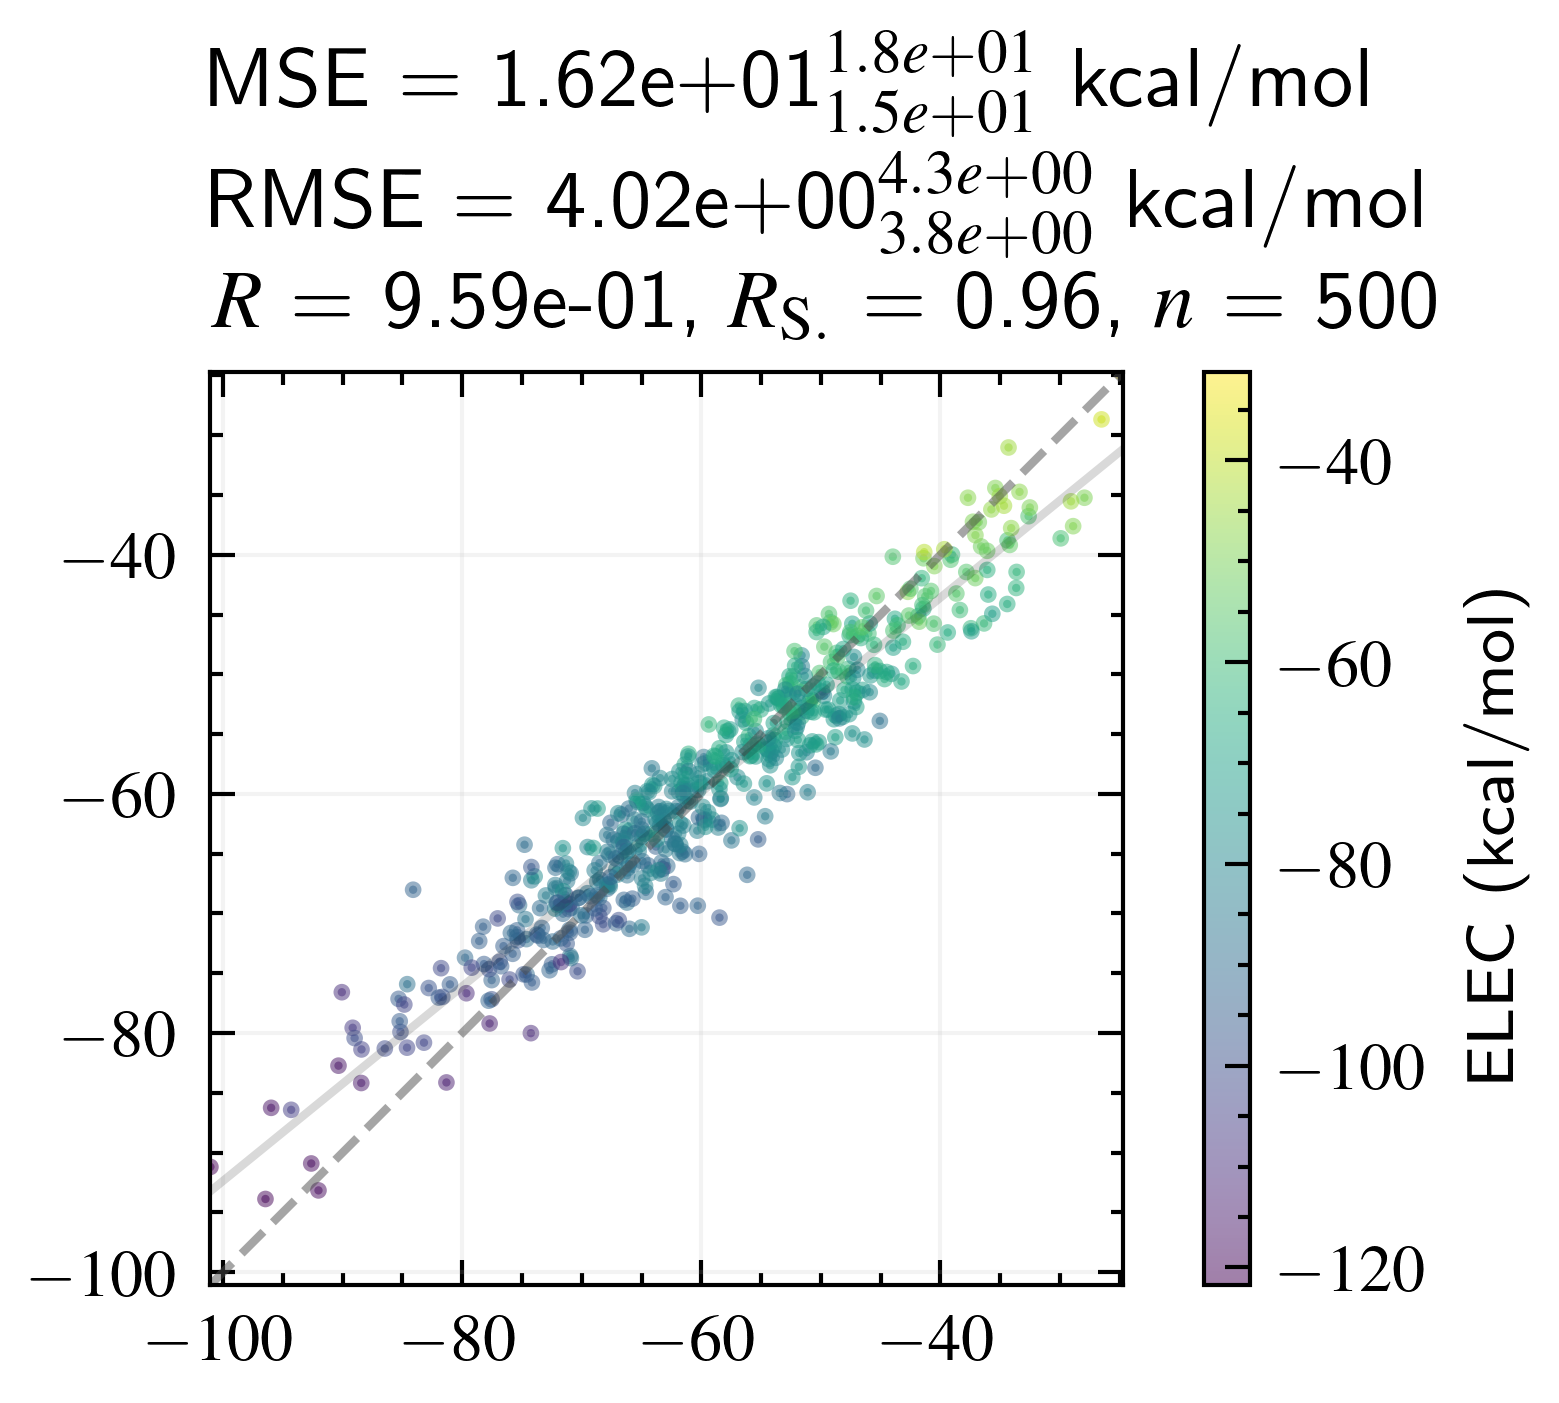

In [26]:
LJFF.data["fit_intE"] = LJFF.eval_jax(bestres) + LJFF.data.ELEC

plot_energy_MSE(LJFF.data, "intE", "fit_intE",  elec = "ELEC")
plt.savefig("kmdcm_harmonic_lj_fit.pdf")


In [18]:
# _c = next(read_from_pickle(f"ff/{ffpkl}"))
LJFF = next(read_from_pickle(f"ff/fit_ECOL_kmdcm_intE.pkl"))

In [22]:
LJFF.elec = "epol_mike"
LJFF.intE = "intE"
LJFF.intern = "Exact"
LJFF.set_intE()
LJFF.set_targets()
print(LJFF.targets.mean())
LJFF

88.23172


FF: LJ water_cluster epol_mike Exact intE (jax_coloumb: True)

In [24]:
LJ_bound

((0.001, 2.5), (0.001, 2.5), (0.001, 2.5), (0.001, 2.5))

In [ ]:
fit_repeat(LJFF, 
           15, 
           f"{ffpkl}_LJ",
           bounds = LJ_bound,
           loss="jax",
           quiet='true'
          )

In [21]:
pd.DataFrame(LJFF.opt_results).sort_values("fun")

,fun,nit,nfev,status,success,message,x,final_simplex
7,16.195114,385,685,0,True,Optimization terminated successfully.,"[0.001, 1.8075449678683502, 0.2342334456853799...","([[0.001, 1.8075449678683502, 0.23423344568537..."
2,20.635584,91,182,0,True,Optimization terminated successfully.,"[0.001, 2.37682358759135, 2.5, 0.001]","([[0.001, 2.37682358759135, 2.5, 0.001], [0.00..."
9,21.945210,680,1187,0,True,Optimization terminated successfully.,"[1.5683227388679306, 1.7245826768708499, 0.001...","([[1.5683227388679306, 1.7245826768708499, 0.0..."
15,30.692957,304,549,0,True,Optimization terminated successfully.,"[1.6992994210533365, 0.7577646404670293, 0.001...","([[1.6992994210533365, 0.7577646404670293, 0.0..."
4,103.624413,126,248,0,True,Optimization terminated successfully.,"[1.863996680384731, 0.001, 0.001, 0.001]","([[1.863996680384731, 0.001, 0.001, 0.001], [1..."
0,134.366913,132,323,0,True,Optimization terminated successfully.,"[1496.1463249145506, 1437.977921449105, 1528.3...","([[1496.1463249145506, 1437.977921449105, 1528..."
3,418.809387,46,154,0,True,Optimization terminated successfully.,"[0.001, 0.029737538352729187, 0.83994214148901...","([[0.001, 0.029737538352729187, 0.839942141489..."
5,418.809387,40,137,0,True,Optimization terminated successfully.,"[0.001, 0.0630635932327347, 2.485934411934334,...","([[0.001, 0.0630635932327347, 2.48593441193433..."
6,418.809387,37,126,0,True,Optimization terminated successfully.,"[0.001, 0.06572866782652684, 0.389662713871651...","([[0.001, 0.06572866782652684, 0.3896627138716..."
8,418.809387,44,152,0,True,Optimization terminated successfully.,"[0.001, 0.04996762805236199, 1.726869319806821...","([[0.001, 0.04996762805236199, 1.7268693198068..."


In [22]:
bestres = list(pd.DataFrame(\
                  LJFF.opt_results)\
     .sort_values("fun").x)[0]
bestres

array([1.00000000e-03, 1.80754497e+00, 2.34233446e-01, 1.25002012e-01])

In [23]:
abs(LJFF.eval_jax(bestres)).mean()

Array(19.0571, dtype=float32)

In [24]:
abs(LJFF.targets).mean()

Array(19.06541, dtype=float32)

In [25]:
best = list(pd.DataFrame(\
                  LJFF.opt_results)\
     .sort_values("fun").fun)[0]
np.sqrt(best)

4.024315362361924

2.6835648048822207e-274


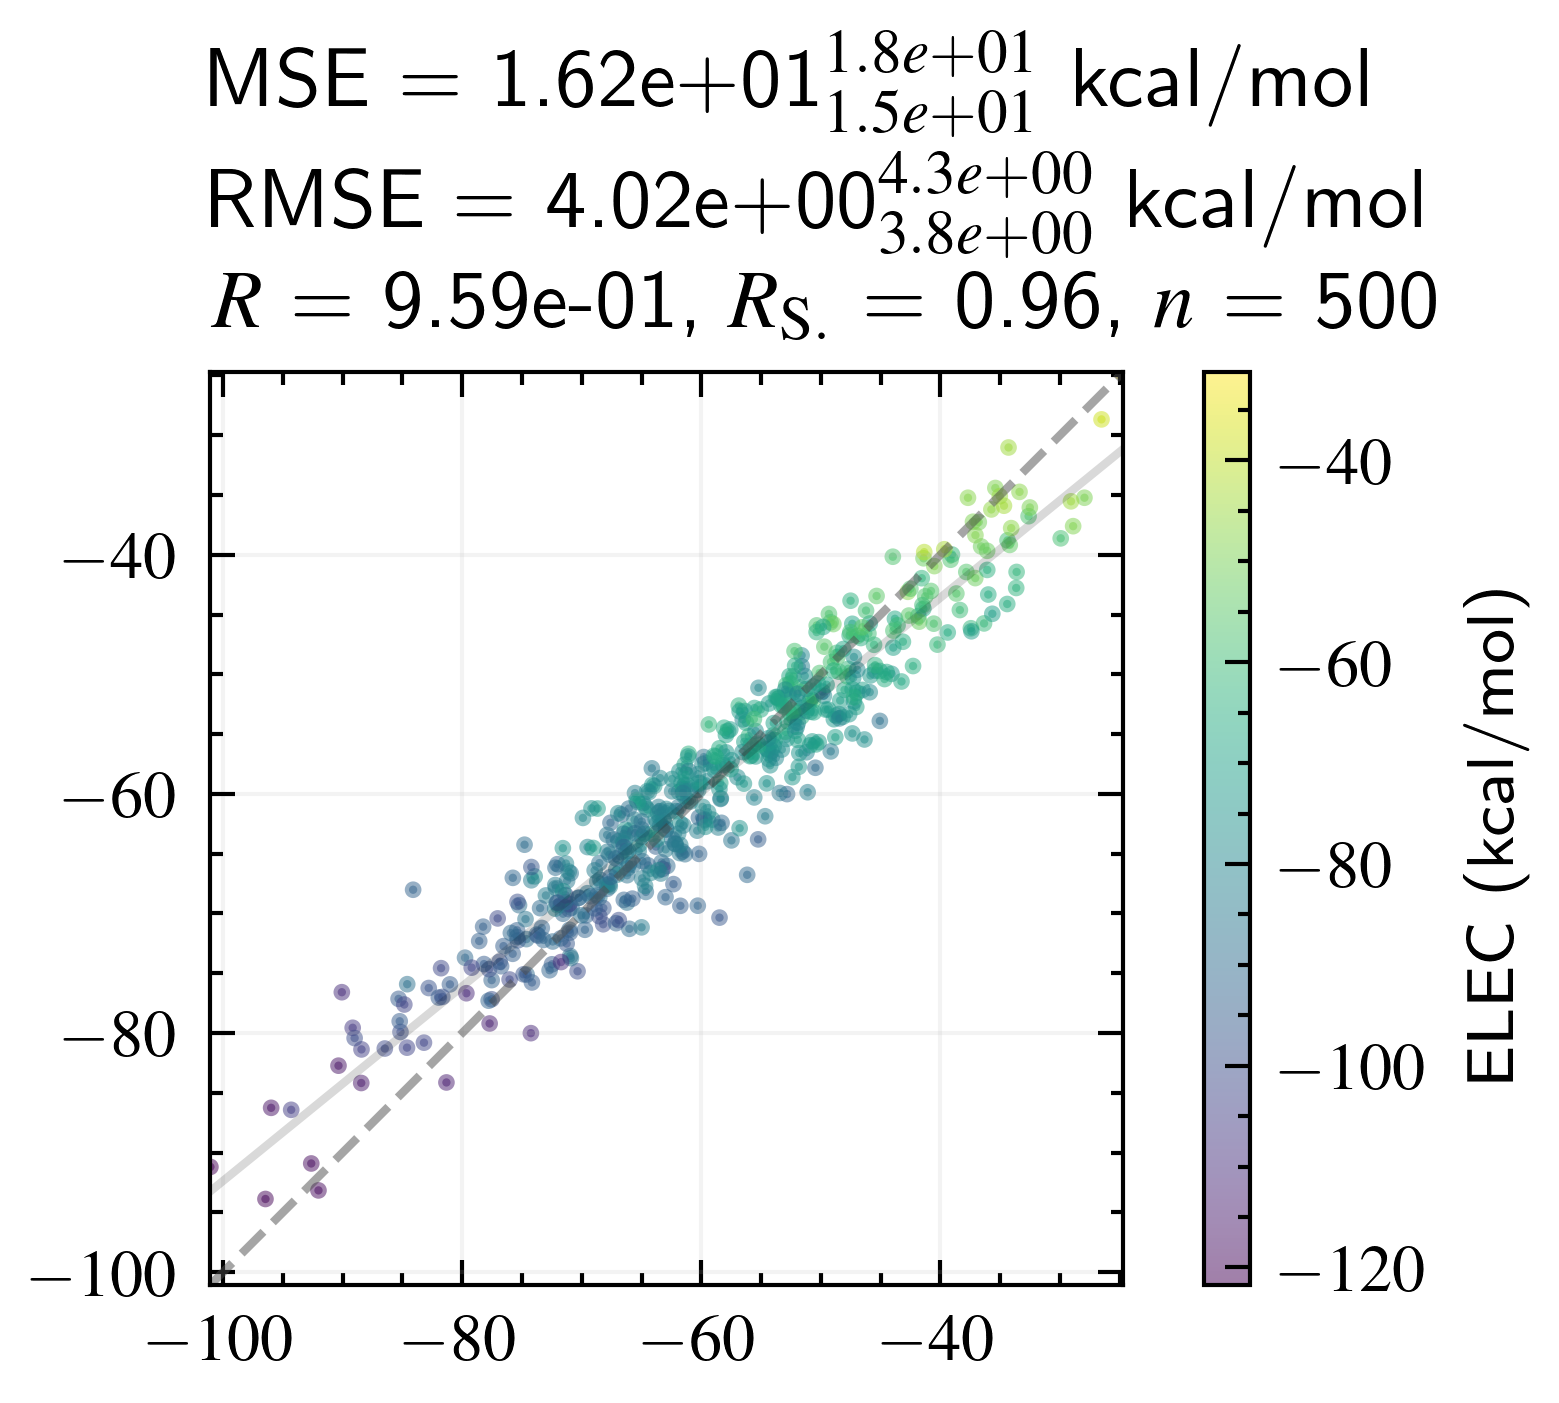

In [26]:
LJFF.data["fit_intE"] = LJFF.eval_jax(bestres) + LJFF.data.ELEC

plot_energy_MSE(LJFF.data, "intE", "fit_intE",  elec = "ELEC")
plt.savefig("kmdcm_harmonic_lj_fit.pdf")


#  LJ fit exact


In [27]:
# _c = next(read_from_pickle(f"ff/{ffpkl}"))
LJFF = next(read_from_pickle(f"ff/fit_ECOL_kmdcm_intE.pkl"))
LJFF

FF: LJ water_cluster ELEC harmonic ECOL (jax_coloumb: True)

In [28]:
# p = PKL_PATH / "water_cluster/pbe0dz/pbe0_dz.pc"
# data_ = Data(p)

In [29]:
# data_.data

In [30]:
# data_.monomer_df

In [31]:
LJFF.data

,ECOL,KEY,TOTAL,ELEC,VDW,KEY,M_ENERGY,KEY,n_monomers,C_ENERGY,...,P_intE,m_E_tot,p_m_E_tot,C_ENERGY_kcalmol,DUMMY,k,epol_mike,first_order_energy,epol_pairs,fit_ECOL
test0,-173.022645,test0,24.14023,-104.54998,20.41138,test0,-1527.133263,test0,20,-1527.276175,...,-77.478222,958362.266640,-958281.958385,-958370.381547,0,0,-197.910658,7.640822,-182.982917,-165.142944
test1,-105.096240,test1,25.25058,-63.45565,8.97296,test1,-1527.135387,test1,20,-1527.221635,...,-53.285800,958360.933743,-958282.584949,-958336.157791,0,1,-113.959761,-5.902676,-111.406093,-105.509087
test2,-144.567121,test2,24.75756,-89.34864,14.41942,test2,-1527.140946,test2,20,-1527.260418,...,-70.885989,958357.445616,-958285.865741,-958360.493844,0,2,-160.484782,-6.037152,-153.110225,-157.379913
test3,-105.558619,test3,21.75948,-62.57541,5.74741,test3,-1527.151295,test3,20,-1527.247454,...,-58.662892,958350.951437,-958292.985598,-958352.359334,0,3,-118.662845,-4.570214,-111.548989,-109.259064
test4,-141.957058,test4,21.69034,-90.29468,12.55821,test4,-1527.150321,test4,20,-1527.270835,...,-73.371184,958351.562845,-958292.418135,-958367.030618,0,4,-155.773808,-12.251942,-151.839749,-148.200836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
test495,-156.403481,test495,24.92171,-95.04093,17.54292,test495,-1527.129876,test495,20,-1527.255655,...,-72.611238,958364.391623,-958280.758013,-958357.505436,0,495,-175.806320,-1.718463,-166.329665,-155.439667
test496,-126.839243,test496,15.65968,-75.31144,12.74644,test496,-1527.168887,test496,20,-1527.264530,...,-61.118914,958339.912612,-958304.589688,-958363.074582,0,496,-138.410126,2.169631,-133.079412,-124.157227
test497,-160.377711,test497,20.65947,-90.76807,24.76786,test497,-1527.154064,test497,20,-1527.248923,...,-57.960443,958349.213649,-958294.973785,-958353.280867,0,497,-178.929213,31.250204,-170.886865,-170.427658
test498,-154.210967,test498,21.38907,-87.19819,20.35679,test498,-1527.150078,test498,20,-1527.257280,...,-65.470853,958351.715184,-958293.538913,-958358.525003,0,498,-171.903376,15.363398,-164.288222,-145.085831


In [32]:
LJFF.elec = "ELEC"
LJFF.intE = "intE"
LJFF.intern = "Exact"
LJFF.set_intE()
LJFF.set_targets()
print(LJFF.targets.mean())
LJFF

17.971722


FF: LJ water_cluster ELEC Exact intE (jax_coloumb: True)

In [33]:
fit_repeat(LJFF, 
           10, 
           f"{ffpkl}_LJ",
           bounds = LJ_bound,
           loss="jax",
           quiet='true'
          )

/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:179: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


In [34]:
pd.DataFrame(LJFF.opt_results).sort_values("fun")

,fun,nit,nfev,status,success,message,x,final_simplex
10,16.056070,435,760,0,True,Optimization terminated successfully.,"[0.001, 1.8000731051963346, 0.3418154693341551...","([[0.001, 1.8000731051963346, 0.34181546933415..."
8,16.077303,191,349,0,True,Optimization terminated successfully.,"[0.07591038712166506, 1.8019757124292164, 0.23...","([[0.07591038712166506, 1.8019757124292164, 0...."
7,16.080706,332,600,0,True,Optimization terminated successfully.,"[0.17181379979737033, 1.773055282823563, 0.028...","([[0.17181379979737033, 1.773055282823563, 0.0..."
2,16.098700,233,434,0,True,Optimization terminated successfully.,"[0.06258058408582501, 1.7581189915412125, 0.00...","([[0.06258058408582501, 1.7581189915412125, 0...."
1,21.602224,514,880,0,True,Optimization terminated successfully.,"[1.4202628021647066, 1.7377627675168916, 0.002...","([[1.4202628021647066, 1.7377627675168916, 0.0..."
0,134.366913,132,323,0,True,Optimization terminated successfully.,"[1496.1463249145506, 1437.977921449105, 1528.3...","([[1496.1463249145506, 1437.977921449105, 1528..."
3,378.385254,42,149,0,True,Optimization terminated successfully.,"[0.05304838313039528, 0.001, 0.038594859209802...","([[0.05304838313039528, 0.001, 0.0385948592098..."
4,378.385254,45,147,0,True,Optimization terminated successfully.,"[0.05127045867744279, 0.001, 0.534852777339636...","([[0.05127045867744279, 0.001, 0.5348527773396..."
5,378.385254,36,145,0,True,Optimization terminated successfully.,"[0.001, 0.001, 1.4148518703577024, 1.784410110...","([[0.001, 0.001, 1.4148518703577024, 1.7844101..."
6,378.385254,42,149,0,True,Optimization terminated successfully.,"[0.035212119737029035, 0.001, 0.57729268810096...","([[0.035212119737029035, 0.001, 0.577292688100..."


In [35]:
bestres = list(pd.DataFrame(\
                  LJFF.opt_results)\
     .sort_values("fun").x)[0]
bestres

array([1.00000000e-03, 1.80007311e+00, 3.41815469e-01, 1.34204508e-01])

In [36]:
abs(LJFF.eval_jax(bestres)).mean()

Array(17.98161, dtype=float32)

In [37]:
abs(LJFF.targets).mean()

Array(17.977665, dtype=float32)

In [38]:
best = list(pd.DataFrame(\
                  LJFF.opt_results)\
     .sort_values("fun").fun)[0]
np.sqrt(best)

4.007002661311668

5.681901602009087e-274


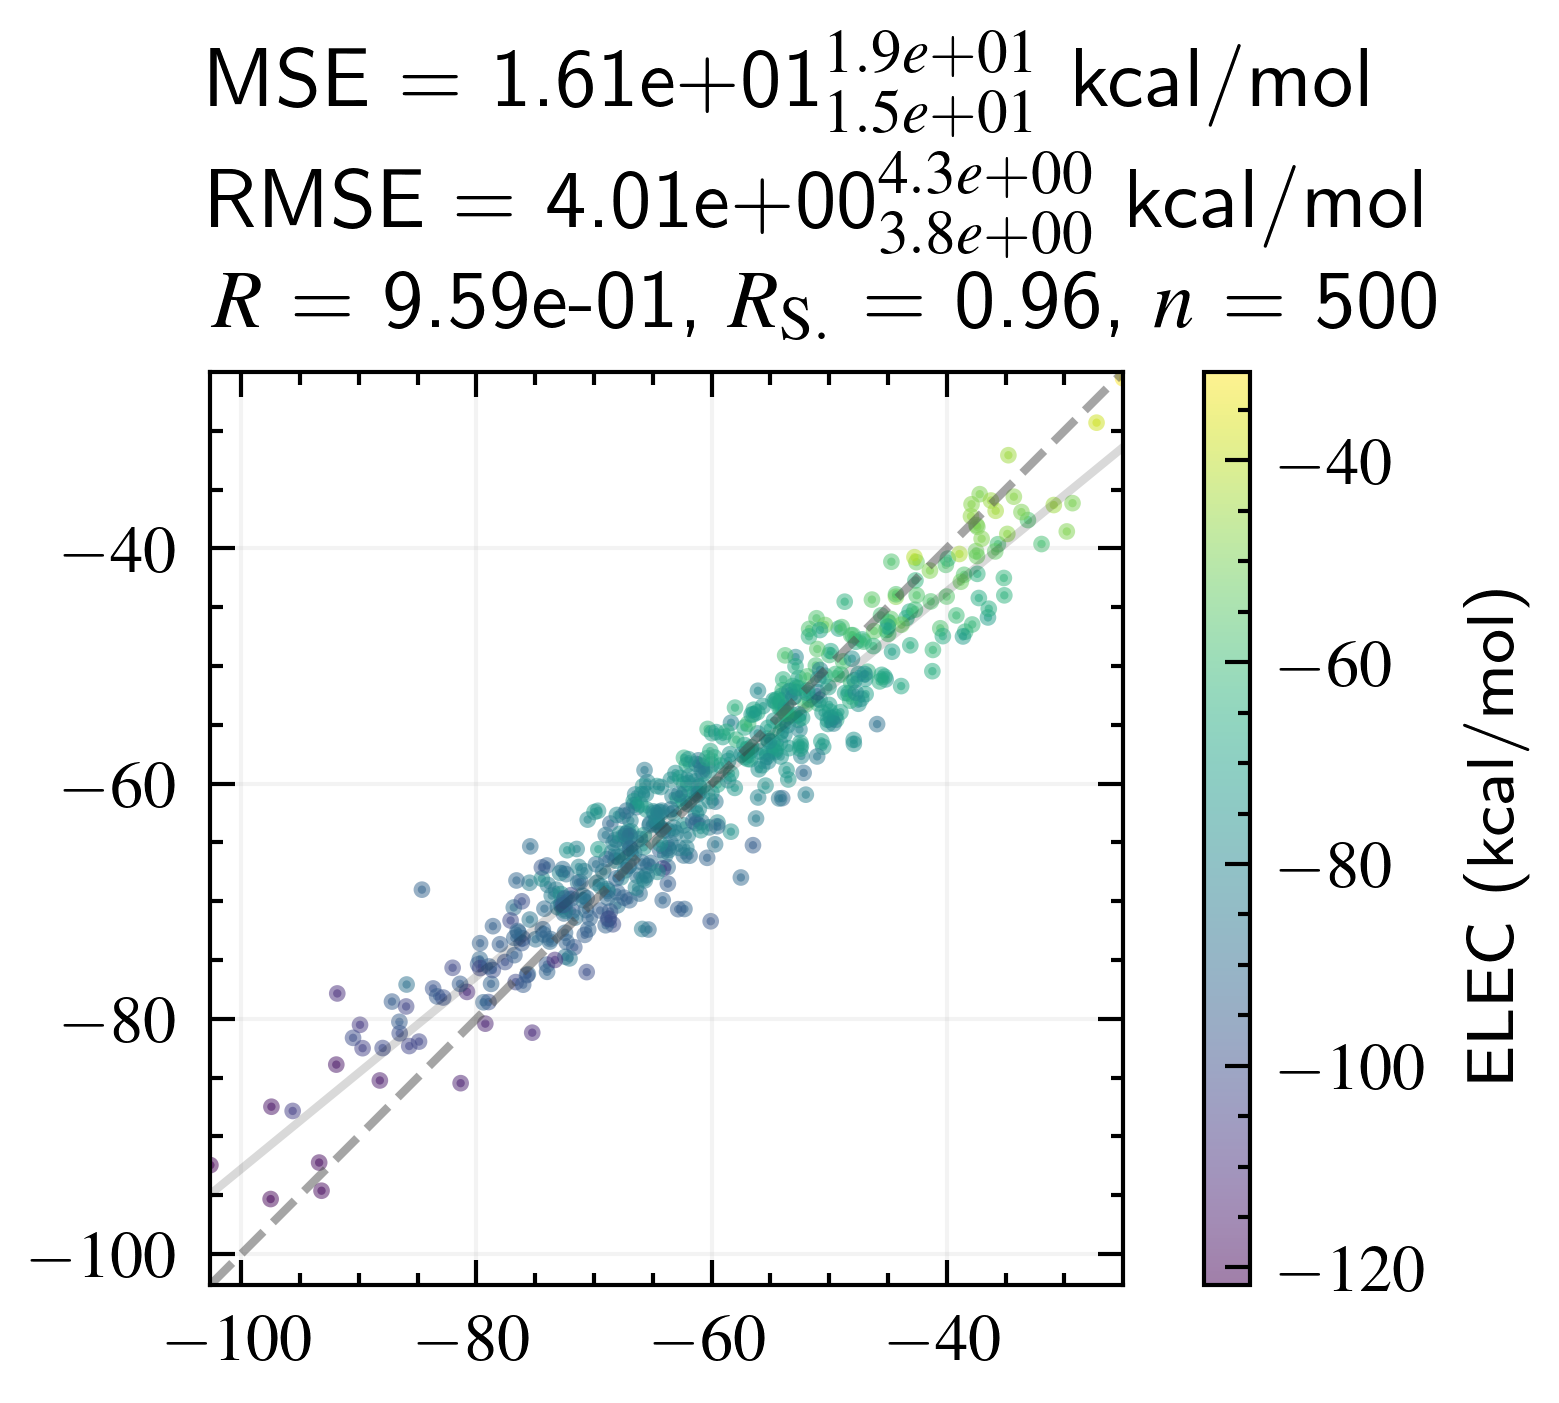

In [39]:
LJFF.data["fit_intE"] = LJFF.eval_jax(bestres) + LJFF.data.ELEC

plot_energy_MSE(LJFF.data, "intE", "fit_intE",  elec = "ELEC")
plt.savefig("kmdcm_exact_lj_fit.pdf")


In [69]:
# LJFF.elec = "fit_ECOL"
# LJFF.intE = "intE"
# LJFF.set_intE()
# LJFF.set_targets()
# print(LJFF.targets.mean())
# LJFF

72.770775


FF: LJ water_cluster fit_ECOL harmonic intE (jax_coloumb: True)

#  LJ fit exact, ECOL


In [40]:
# _c = next(read_from_pickle(f"ff/{ffpkl}"))
LJFF = next(read_from_pickle(f"ff/fit_ECOL_kmdcm_intE.pkl"))
LJFF

FF: LJ water_cluster ELEC harmonic ECOL (jax_coloumb: True)

In [53]:
# p = PKL_PATH / "water_cluster/pbe0dz/pbe0_dz.pc"
# data_ = Data(p)

In [54]:
# data_.data

In [55]:
# data_.monomer_df

In [56]:
# LJFF.data

In [41]:
LJFF.elec = "ECOL"
LJFF.intE = "intE"
LJFF.intern = "Exact"
LJFF.set_intE()
LJFF.set_targets()
print(LJFF.targets.mean())
LJFF

73.60582


FF: LJ water_cluster ECOL Exact intE (jax_coloumb: True)

In [97]:
fit_repeat(LJFF, 
           10, 
           f"{ffpkl}_LJ",
           bounds = LJ_bound,
           loss="jax",
           quiet='true'
          )

/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:179: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


In [98]:
pd.DataFrame(LJFF.opt_results).sort_values("fun")

,fun,nit,nfev,status,success,message,x,final_simplex
7,21.204657,163,321,0,True,Optimization terminated successfully.,"[0.001, 2.5, 0.052442977704893985, 0.003771101...","([[0.001, 2.5, 0.052442977704893985, 0.0037711..."
4,21.260790,605,1060,0,True,Optimization terminated successfully.,"[0.001, 2.3104235567465556, 0.1024306623776748...","([[0.001, 2.3104235567465556, 0.10243066237767..."
8,21.832388,527,906,0,True,Optimization terminated successfully.,"[0.04807575809023806, 2.115189994996074, 0.001...","([[0.04807575809023806, 2.115189994996074, 0.0..."
9,21.859806,323,607,0,True,Optimization terminated successfully.,"[0.008884348351164662, 2.11077471676927, 0.001...","([[0.008884348351164662, 2.11077471676927, 0.0..."
0,134.035934,111,281,0,True,Optimization terminated successfully.,"[1895.8678696937782, 1428.0571930052483, 425.0...","([[1895.8678696937782, 1428.0571930052483, 425..."
1,5713.072266,19,33,0,True,Optimization terminated successfully.,"[0.001, 0.001, 2.5, 2.5]","([[0.001, 0.001, 2.5, 2.5], [0.001, 0.001, 2.5..."
2,5713.072266,33,134,0,True,Optimization terminated successfully.,"[0.016834891157025612, 0.001, 2.22797180421986...","([[0.016834891157025612, 0.001, 2.227971804219..."
3,5713.072266,51,162,0,True,Optimization terminated successfully.,"[0.04010428875422828, 0.05711073632754016, 2.3...","([[0.04010428875422828, 0.05711073632754016, 2..."
5,5713.072266,55,168,0,True,Optimization terminated successfully.,"[0.04888373381270443, 0.001, 2.492284599365157...","([[0.04888373381270443, 0.001, 2.4922845993651..."
6,5713.072266,60,179,0,True,Optimization terminated successfully.,"[0.04744973906828187, 0.04480420986732092, 1.5...","([[0.04744973906828187, 0.04480420986732092, 1..."


In [99]:
bestres = list(pd.DataFrame(\
                  LJFF.opt_results)\
     .sort_values("fun").x)[0]
bestres

array([1.00000000e-03, 2.50000000e+00, 5.24429777e-02, 3.77110140e-03])

In [100]:
abs(LJFF.eval_jax(bestres)).mean()

Array(73.67436, dtype=float32)

In [101]:
abs(LJFF.targets).mean()

Array(73.60582, dtype=float32)

In [102]:
best = list(pd.DataFrame(\
                  LJFF.opt_results)\
     .sort_values("fun").fun)[0]
np.sqrt(best)

4.604851420073415

3.7472721982508165e-230


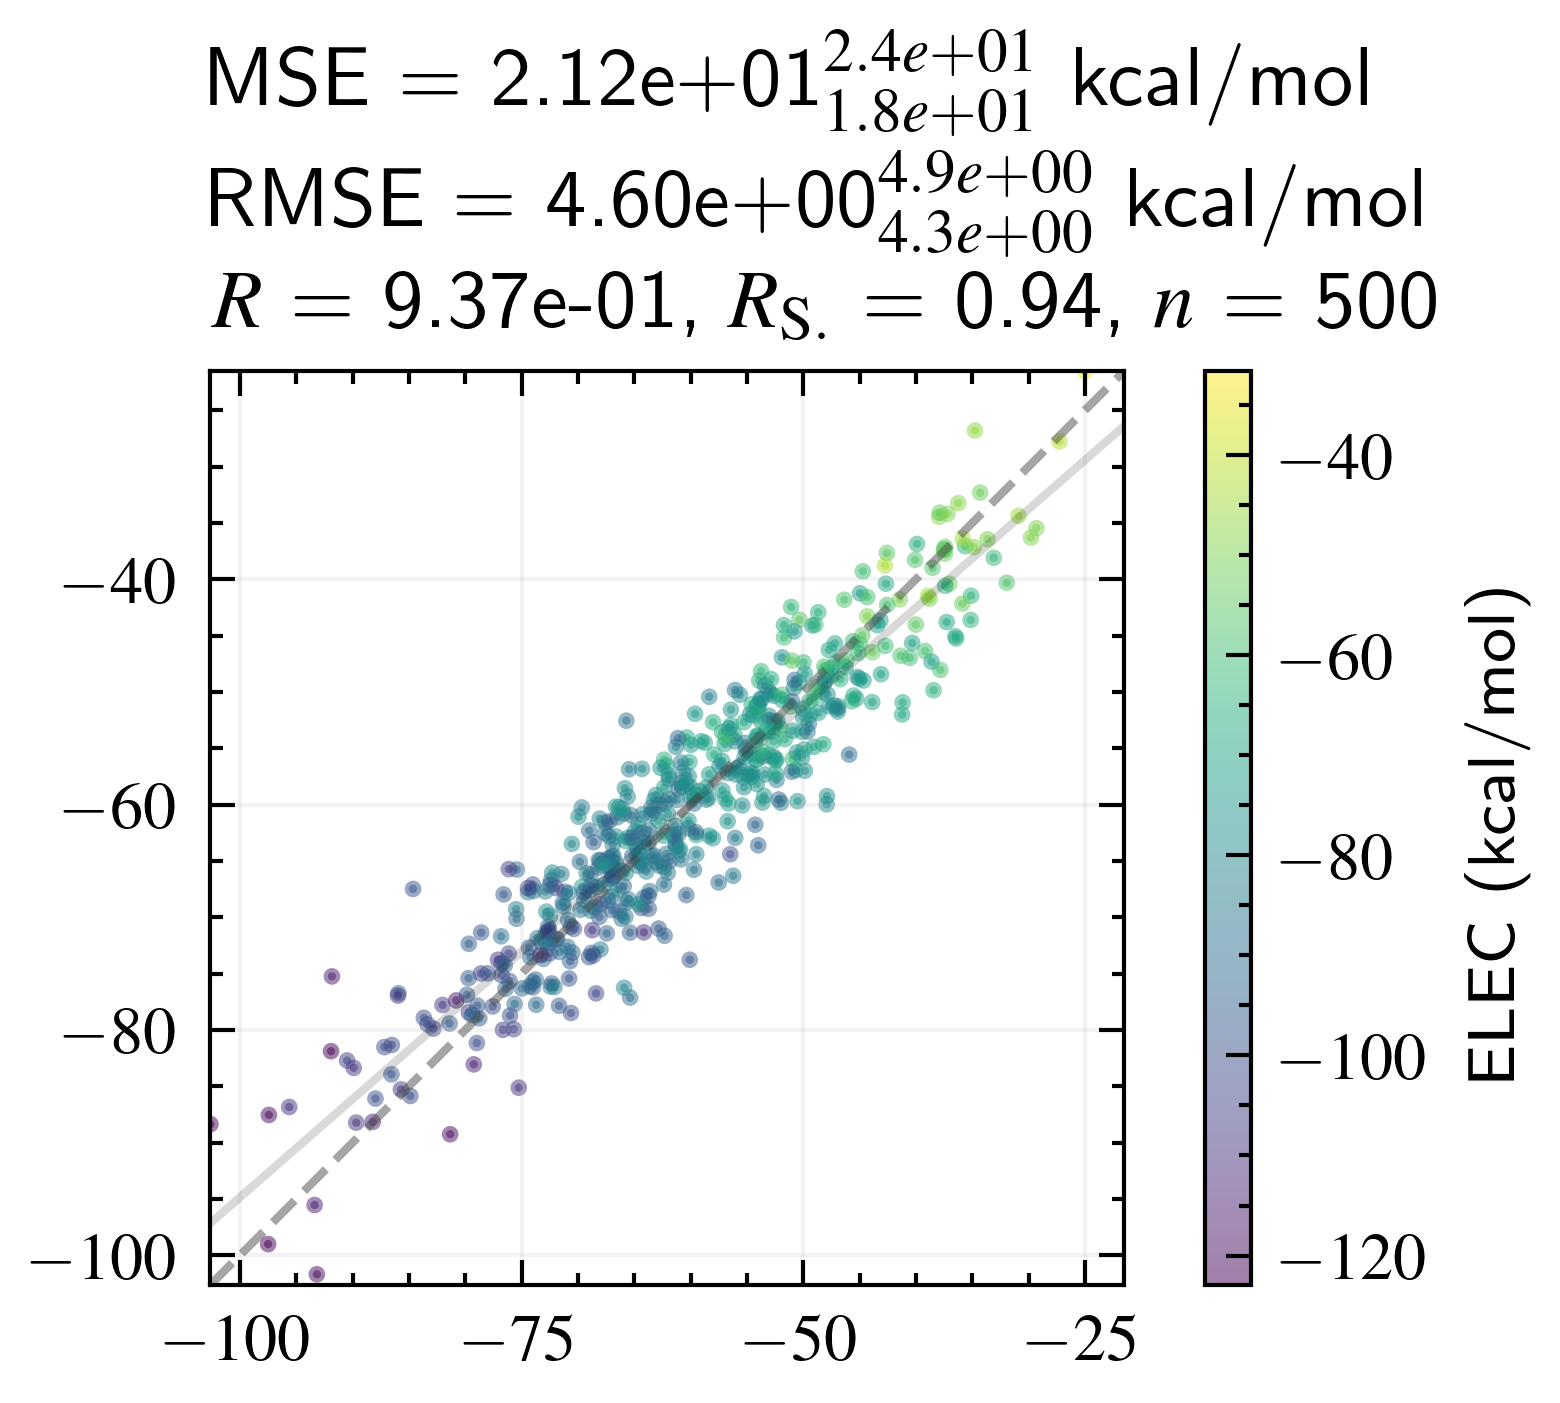

In [103]:
LJFF.data["fit_intE"] = LJFF.eval_jax(bestres) + LJFF.data.ECOL

plot_energy_MSE(LJFF.data, "intE", "fit_intE",  elec = "ELEC")
plt.savefig("ecol_exact_lj_fit.pdf")


#  LJ fit exact, ECOL fit


In [42]:
# _c = next(read_from_pickle(f"ff/{ffpkl}"))
LJFF = next(read_from_pickle(f"ff/fit_ECOL_kmdcm_intE.pkl"))
LJFF

FF: LJ water_cluster ELEC harmonic ECOL (jax_coloumb: True)

In [43]:
# p = PKL_PATH / "water_cluster/pbe0dz/pbe0_dz.pc"
# data_ = Data(p)

In [44]:
# data_.data

In [45]:
# data_.monomer_df

In [46]:
# LJFF.data

In [47]:
LJFF.elec = "fit_ECOL"
LJFF.intE = "intE"
LJFF.intern = "Exact"
LJFF.set_intE()
LJFF.set_targets()
print(LJFF.targets.mean())
LJFF

71.63602


FF: LJ water_cluster fit_ECOL Exact intE (jax_coloumb: True)

In [48]:
fit_repeat(LJFF, 
           10, 
           f"{ffpkl}_LJ",
           bounds = LJ_bound,
           loss="jax",
           quiet='true'
          )

/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:179: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


In [49]:
pd.DataFrame(LJFF.opt_results).sort_values("fun")

,fun,nit,nfev,status,success,message,x,final_simplex
1,121.090706,614,1064,0,True,Optimization terminated successfully.,"[0.18155859006192465, 2.4999892661589342, 0.00...","([[0.18155859006192465, 2.4999892661589342, 0...."
9,121.106247,647,1135,0,True,Optimization terminated successfully.,"[0.23739171148436772, 2.4999719086818692, 0.00...","([[0.23739171148436772, 2.4999719086818692, 0...."
5,121.138008,659,1146,0,True,Optimization terminated successfully.,"[0.0836732942126217, 2.4999948049562564, 0.002...","([[0.0836732942126217, 2.4999948049562564, 0.0..."
4,121.143555,656,1117,0,True,Optimization terminated successfully.,"[0.01771834609123972, 2.5, 0.001, 0.0039344109...","([[0.01771834609123972, 2.5, 0.001, 0.00393441..."
0,134.366913,132,323,0,True,Optimization terminated successfully.,"[1496.1463249145506, 1437.977921449105, 1528.3...","([[1496.1463249145506, 1437.977921449105, 1528..."
10,134.482605,319,597,0,True,Optimization terminated successfully.,"[0.001, 2.1347510445155766, 0.7065100065736939...","([[0.001, 2.1347510445155766, 0.70651000657369..."
2,159.031418,265,481,0,True,Optimization terminated successfully.,"[0.06007752904123744, 2.1666868090279365, 1.92...","([[0.06007752904123744, 2.1666868090279365, 1...."
6,181.817291,616,1057,0,True,Optimization terminated successfully.,"[1.0870969585001058, 2.5, 0.001, 0.00104723463...","([[1.0870969585001058, 2.5, 0.001, 0.001047234..."
8,230.303329,537,946,0,True,Optimization terminated successfully.,"[1.4967419454461794, 2.0698446456635775, 0.001...","([[1.4967419454461794, 2.0698446456635775, 0.0..."
3,5448.357422,51,155,0,True,Optimization terminated successfully.,"[0.001, 0.001, 2.5, 2.5]","([[0.001, 0.001, 2.5, 2.5], [0.001000836196274..."


In [50]:
bestres = list(pd.DataFrame(\
                  LJFF.opt_results)\
     .sort_values("fun").x)[0]
bestres

array([1.81558590e-01, 2.49998927e+00, 1.00000000e-03, 3.85473258e-03])

In [51]:
abs(LJFF.eval_jax(bestres)).mean()

Array(71.36874, dtype=float32)

In [52]:
abs(LJFF.targets).mean()

Array(71.63602, dtype=float32)

In [53]:
best = list(pd.DataFrame(\
                  LJFF.opt_results)\
     .sort_values("fun").fun)[0]
np.sqrt(best)

11.004122221766806

3.96311274509171e-221


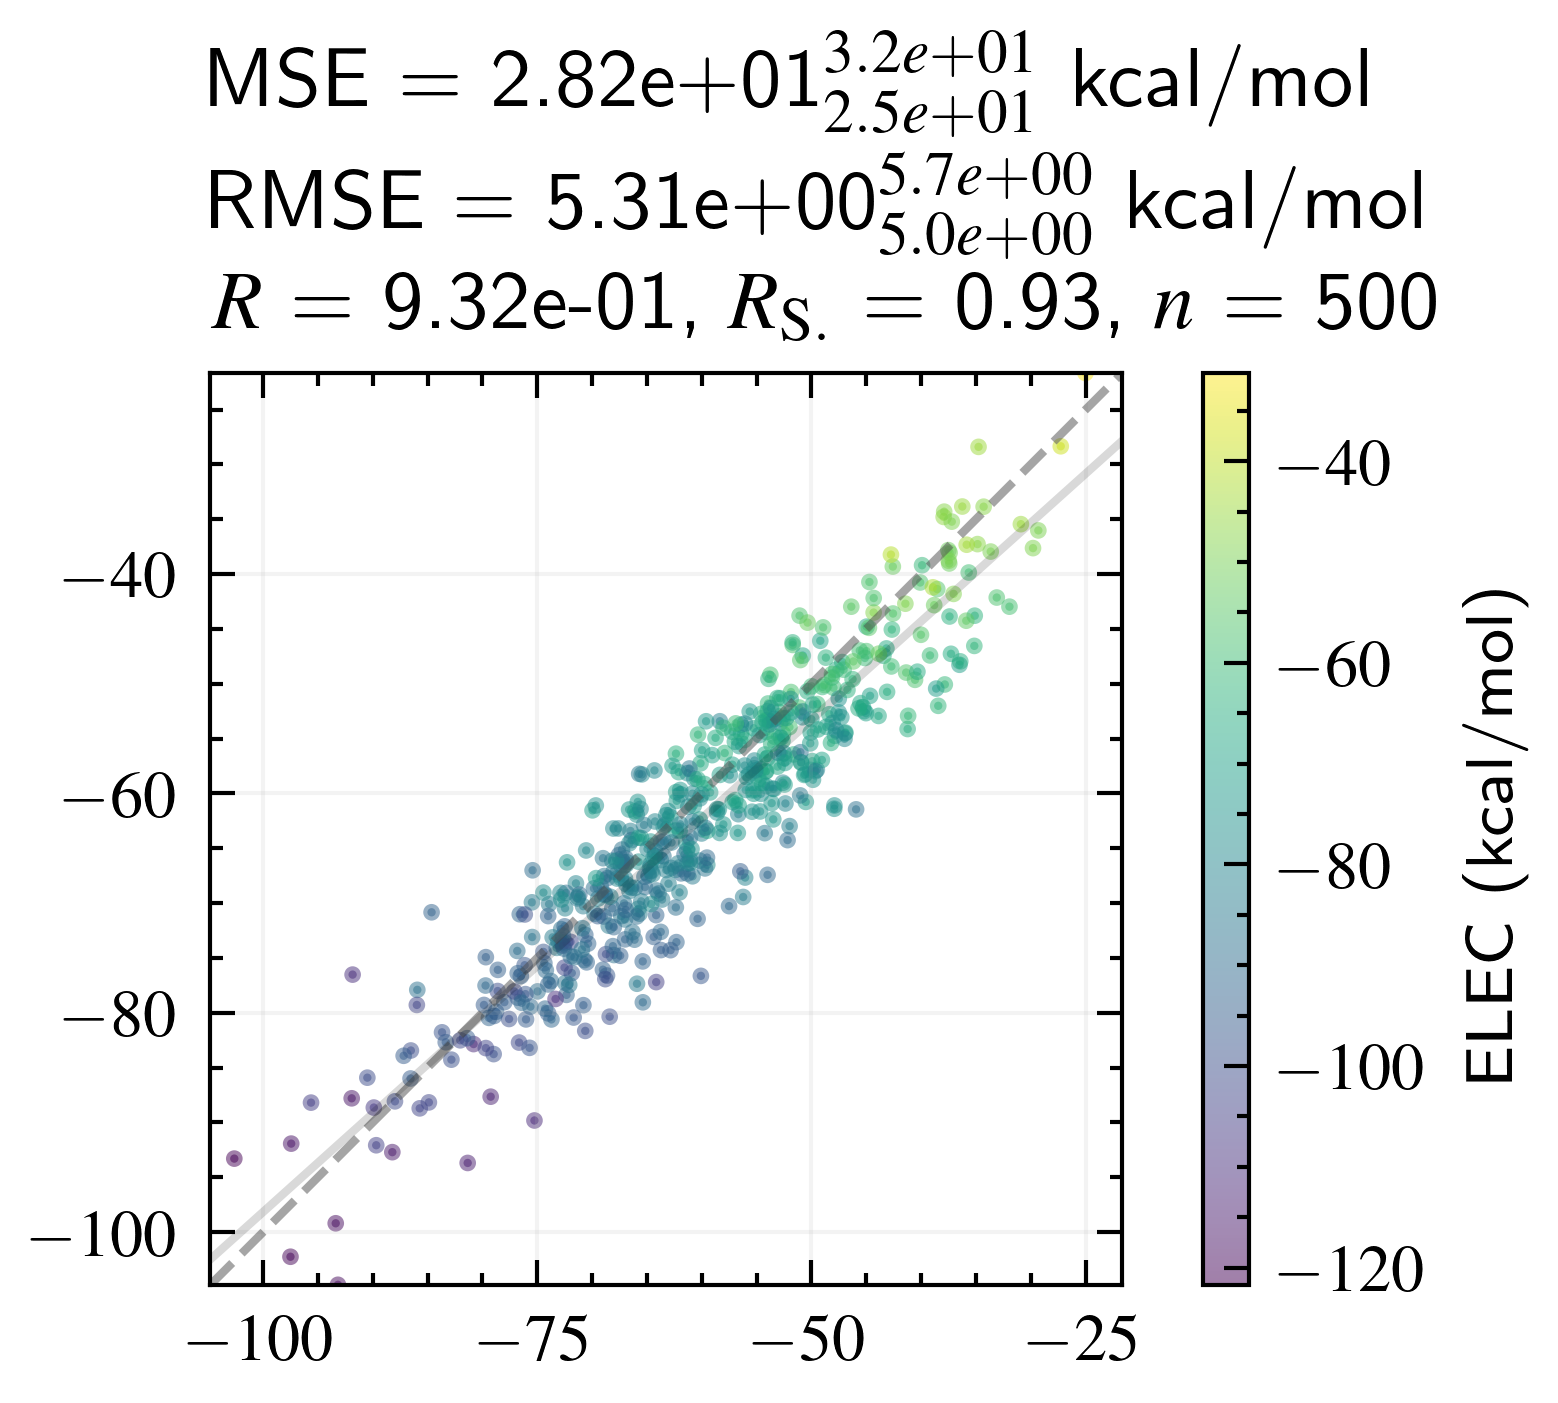

In [55]:
LJFF.data["fit_intE"] = LJFF.eval_jax(bestres) + LJFF.data.ECOL

plot_energy_MSE(LJFF.data, "intE", "fit_intE",  elec = "ELEC")
plt.savefig("kmdcm_ecol_fit_exact_lj_fit.pdf")


#  LJ fit harmonic, ECOL fit


In [70]:
# _c = next(read_from_pickle(f"ff/{ffpkl}"))
LJFF = next(read_from_pickle(f"ff/fit_ECOL_tip3_intE.pkl"))
LJFF

FF: LJ water_cluster ELEC harmonic ECOL (jax_coloumb: True)

In [58]:
# p = PKL_PATH / "water_cluster/pbe0dz/pbe0_dz.pc"
# data_ = Data(p)

In [59]:
# data_.data

In [60]:
# data_.monomer_df

In [61]:
# LJFF.data

In [72]:
LJFF.elec = "fit_ECOL"
LJFF.intE = "intE"
LJFF.intern = "harmonic"
LJFF.set_intE()
LJFF.set_targets()
print(LJFF.targets.mean())
LJFF

73.45566


FF: LJ water_cluster fit_ECOL harmonic intE (jax_coloumb: True)

In [73]:
fit_repeat(LJFF, 
           10, 
           f"{ffpkl}_LJ",
           bounds = LJ_bound,
           loss="jax",
           quiet='true'
          )

/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:179: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


In [74]:
pd.DataFrame(LJFF.opt_results).sort_values("fun")

,fun,nit,nfev,status,success,message,x,final_simplex
1,71.694290,592,1036,0,True,Optimization terminated successfully.,"[0.2394108946356567, 2.5, 0.001, 0.00390726348...","([[0.2394108946356567, 2.5, 0.001, 0.003907263..."
9,71.733078,422,765,0,True,Optimization terminated successfully.,"[0.02305640196626209, 2.499990072662656, 0.001...","([[0.02305640196626209, 2.499990072662656, 0.0..."
8,71.744820,410,704,0,True,Optimization terminated successfully.,"[0.001, 2.5, 0.0011272123076727896, 0.00403550...","([[0.001, 2.5, 0.0011272123076727896, 0.004035..."
6,71.845879,560,943,0,True,Optimization terminated successfully.,"[0.001, 2.4999999611769237, 0.0080285416374640...","([[0.001, 2.4999999611769237, 0.00802854163746..."
2,72.879051,553,990,0,True,Optimization terminated successfully.,"[0.2739918192315576, 2.2829795092251435, 0.001...","([[0.2739918192315576, 2.2829795092251435, 0.0..."
5,78.060135,425,761,0,True,Optimization terminated successfully.,"[0.001, 2.278187435824216, 0.2828617520411762,...","([[0.001, 2.278187435824216, 0.282861752041176..."
7,81.075462,485,859,0,True,Optimization terminated successfully.,"[0.0015982896402723322, 2.2494366836046, 0.477...","([[0.0015982896402723322, 2.2494366836046, 0.4..."
0,95.599182,120,298,0,True,Optimization terminated successfully.,"[1754.4221030693234, 1407.8747311091342, 1977....","([[1754.4221030693234, 1407.8747311091342, 197..."
3,103.510803,313,593,0,True,Optimization terminated successfully.,"[0.001, 2.147273546367762, 2.5, 0.027443760767...","([[0.001, 2.147273546367762, 2.5, 0.0274437607..."
4,5667.767090,64,185,0,True,Optimization terminated successfully.,"[0.011581505543246141, 0.2413230936890809, 0.0...","([[0.011581505543246141, 0.2413230936890809, 0..."


In [75]:
bestres = list(pd.DataFrame(\
                  LJFF.opt_results)\
     .sort_values("fun").x)[0]
bestres

array([2.39410895e-01, 2.50000000e+00, 1.00000000e-03, 3.90726349e-03])

In [76]:
abs(LJFF.eval_jax(bestres)).mean()

Array(73.14068, dtype=float32)

In [77]:
abs(LJFF.targets).mean()

Array(73.45566, dtype=float32)

In [78]:
best = list(pd.DataFrame(\
                  LJFF.opt_results)\
     .sort_values("fun").fun)[0]
np.sqrt(best)

8.467248086665041

6.418034547626314e-227


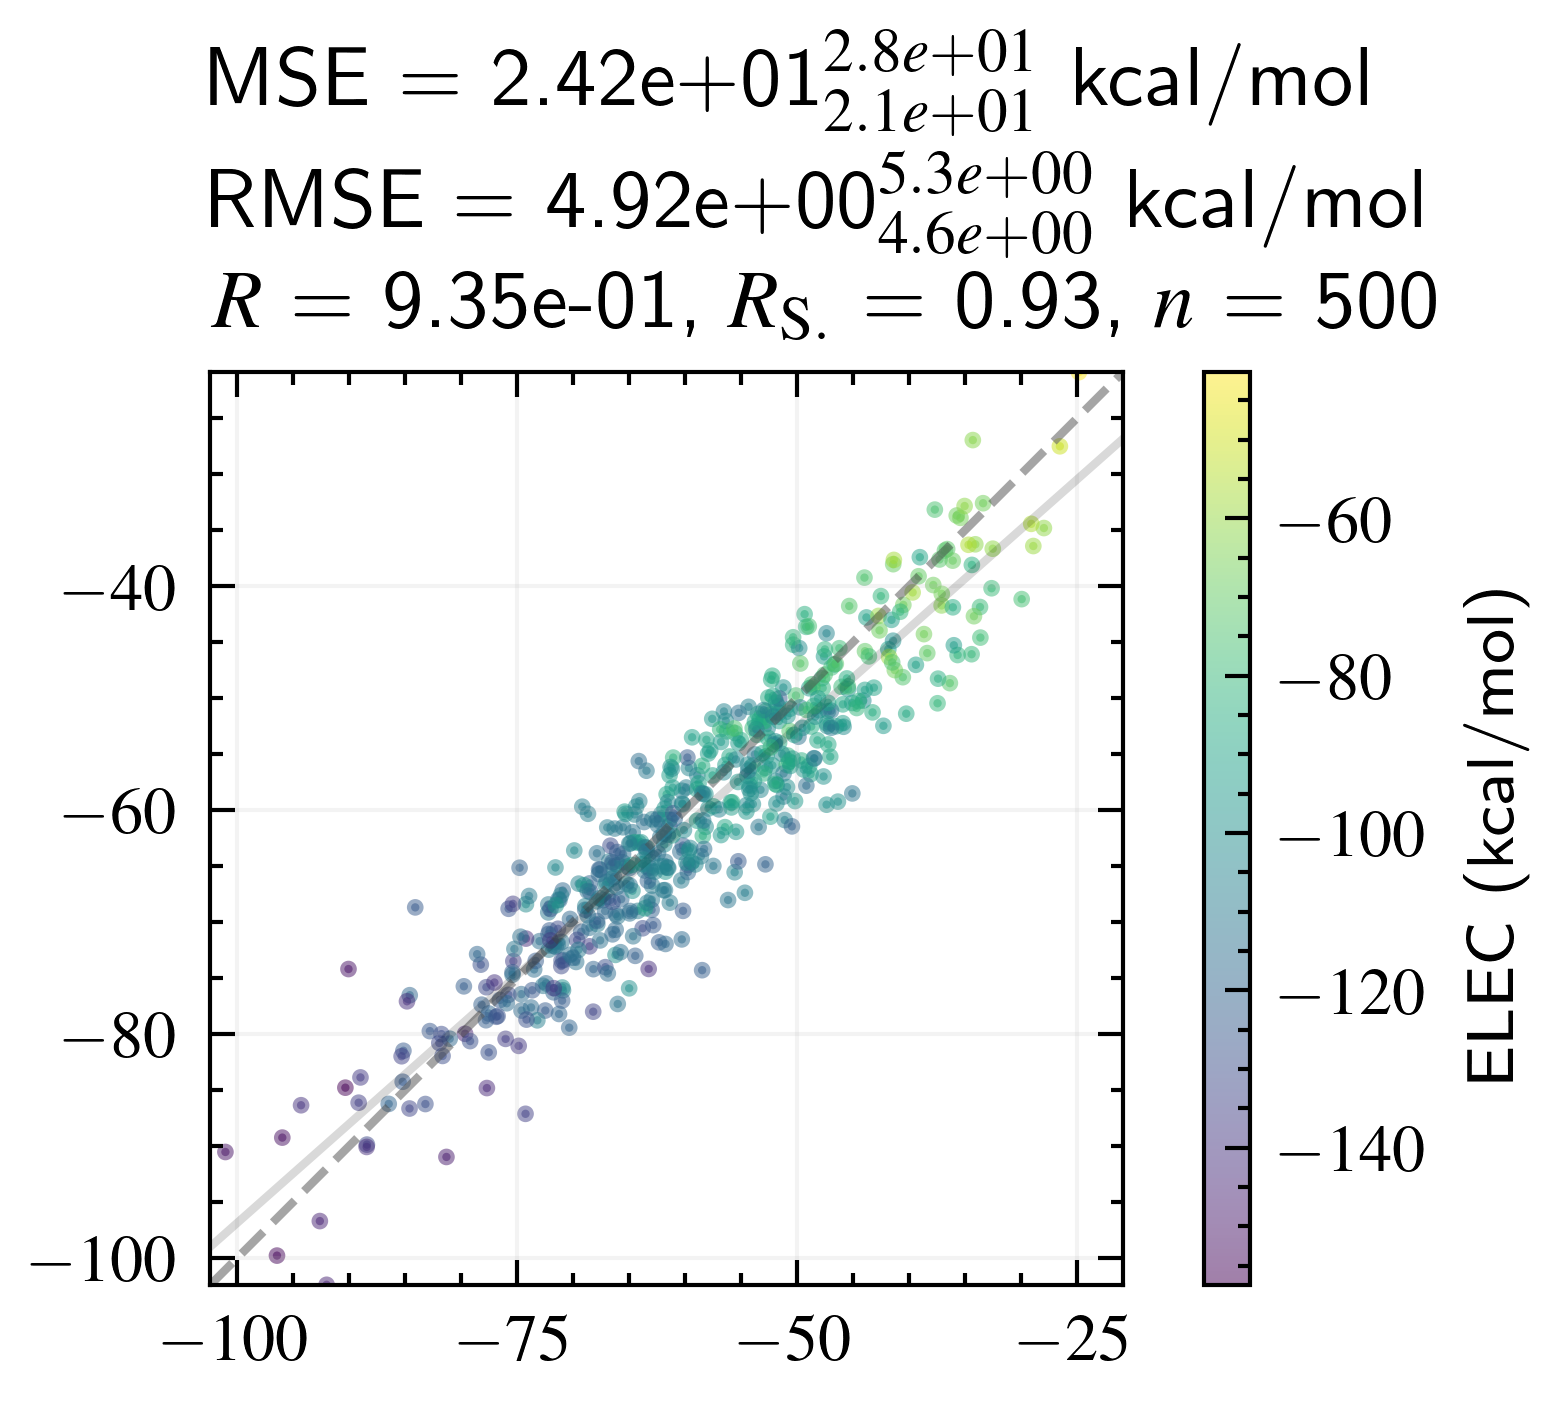

In [80]:
LJFF.data["fit_intE"] = LJFF.eval_jax(bestres) + LJFF.data.ECOL

plot_energy_MSE(LJFF.data, "intE", "fit_intE",  elec = "ELEC")
plt.savefig("tip3_ecol_fit_harmonic_lj_fit.pdf")


#  DE fit


In [23]:
# _c = next(read_from_pickle(f"ff/{ffpkl}"))
DEFF = next(read_from_pickle(f"ff/fit_ECOL_mdcm_intE.pkl"))
DEFF.elec = "fit_ECOL"
DEFF.data.intE.abs().mean()

59.12803914354881

In [24]:
fit_repeat(DEFF, 
           10, 
           "test",
           bounds = DE_bound,
           loss="jax_de",
           quiet='true'
          )

/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:179: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


In [30]:
pd.DataFrame(DEFF.opt_results).sort_values("fun")

,fun,nit,nfev,status,success,message,x,final_simplex
7,11.775151,964,1559,0,True,Optimization terminated successfully.,"[0.3411363344649736, 1.2834539826299567, 2.5, ...","([[0.3411363344649736, 1.2834539826299567, 2.5..."
11,11.775182,596,1013,0,True,Optimization terminated successfully.,"[0.3410279489227199, 1.2835442577247882, 2.499...","([[0.3410279489227199, 1.2835442577247882, 2.4..."
6,11.775245,1476,2327,0,True,Optimization terminated successfully.,"[0.34114571204260147, 1.283410496813493, 2.499...","([[0.34114571204260147, 1.283410496813493, 2.4..."
20,11.775511,1283,2046,0,True,Optimization terminated successfully.,"[0.3406634610028251, 1.2834286543030644, 2.499...","([[0.3406634610028251, 1.2834286543030644, 2.4..."
9,11.776557,581,946,0,True,Optimization terminated successfully.,"[0.3407296851411241, 1.2837287936298885, 2.499...","([[0.3407296851411241, 1.2837287936298885, 2.4..."
17,11.777202,943,1549,0,True,Optimization terminated successfully.,"[0.34070603589209786, 1.2838674274856148, 2.49...","([[0.34070603589209786, 1.2838674274856148, 2...."
1,11.792897,1024,1623,0,True,Optimization terminated successfully.,"[0.3391777333651863, 1.2858844652607933, 2.499...","([[0.3391777333651863, 1.2858844652607933, 2.4..."
16,11.793501,729,1197,0,True,Optimization terminated successfully.,"[0.3392183785149385, 1.2858566511837575, 2.499...","([[0.3392183785149385, 1.2858566511837575, 2.4..."
8,11.793520,1672,2621,0,True,Optimization terminated successfully.,"[0.33895459035051223, 1.2859510668931469, 2.49...","([[0.33895459035051223, 1.2859510668931469, 2...."
18,14.313481,740,1191,0,True,Optimization terminated successfully.,"[0.4379737380241687, 1.1385457267294805, 2.5, ...","([[0.4379737380241687, 1.1385457267294805, 2.5..."


In [27]:
# np.sqrt(10.7)

In [28]:
best = list(pd.DataFrame(\
                  DEFF.opt_results)\
     .sort_values("fun").fun)[0]
np.sqrt(best)

3.4314940263311815

/home/boittier/miniconda3/envs/pycharmm/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


2.0136656937969305e-19


(<Axes: xlabel='NBOND energy\n(kcal/mol)', ylabel='CCSD(T) interaction energy\n(kcal/mol)'>,
 {'MSE': 1.2343012918828257e+76,
  'RMSE': 1.110991130424913e+38,
  'R': -0.38811610661346574,
  'RS': -0.3537352069408277,
  'n': 500,
  'slope': -9.093174018307893e+35,
  'intercept': inf})

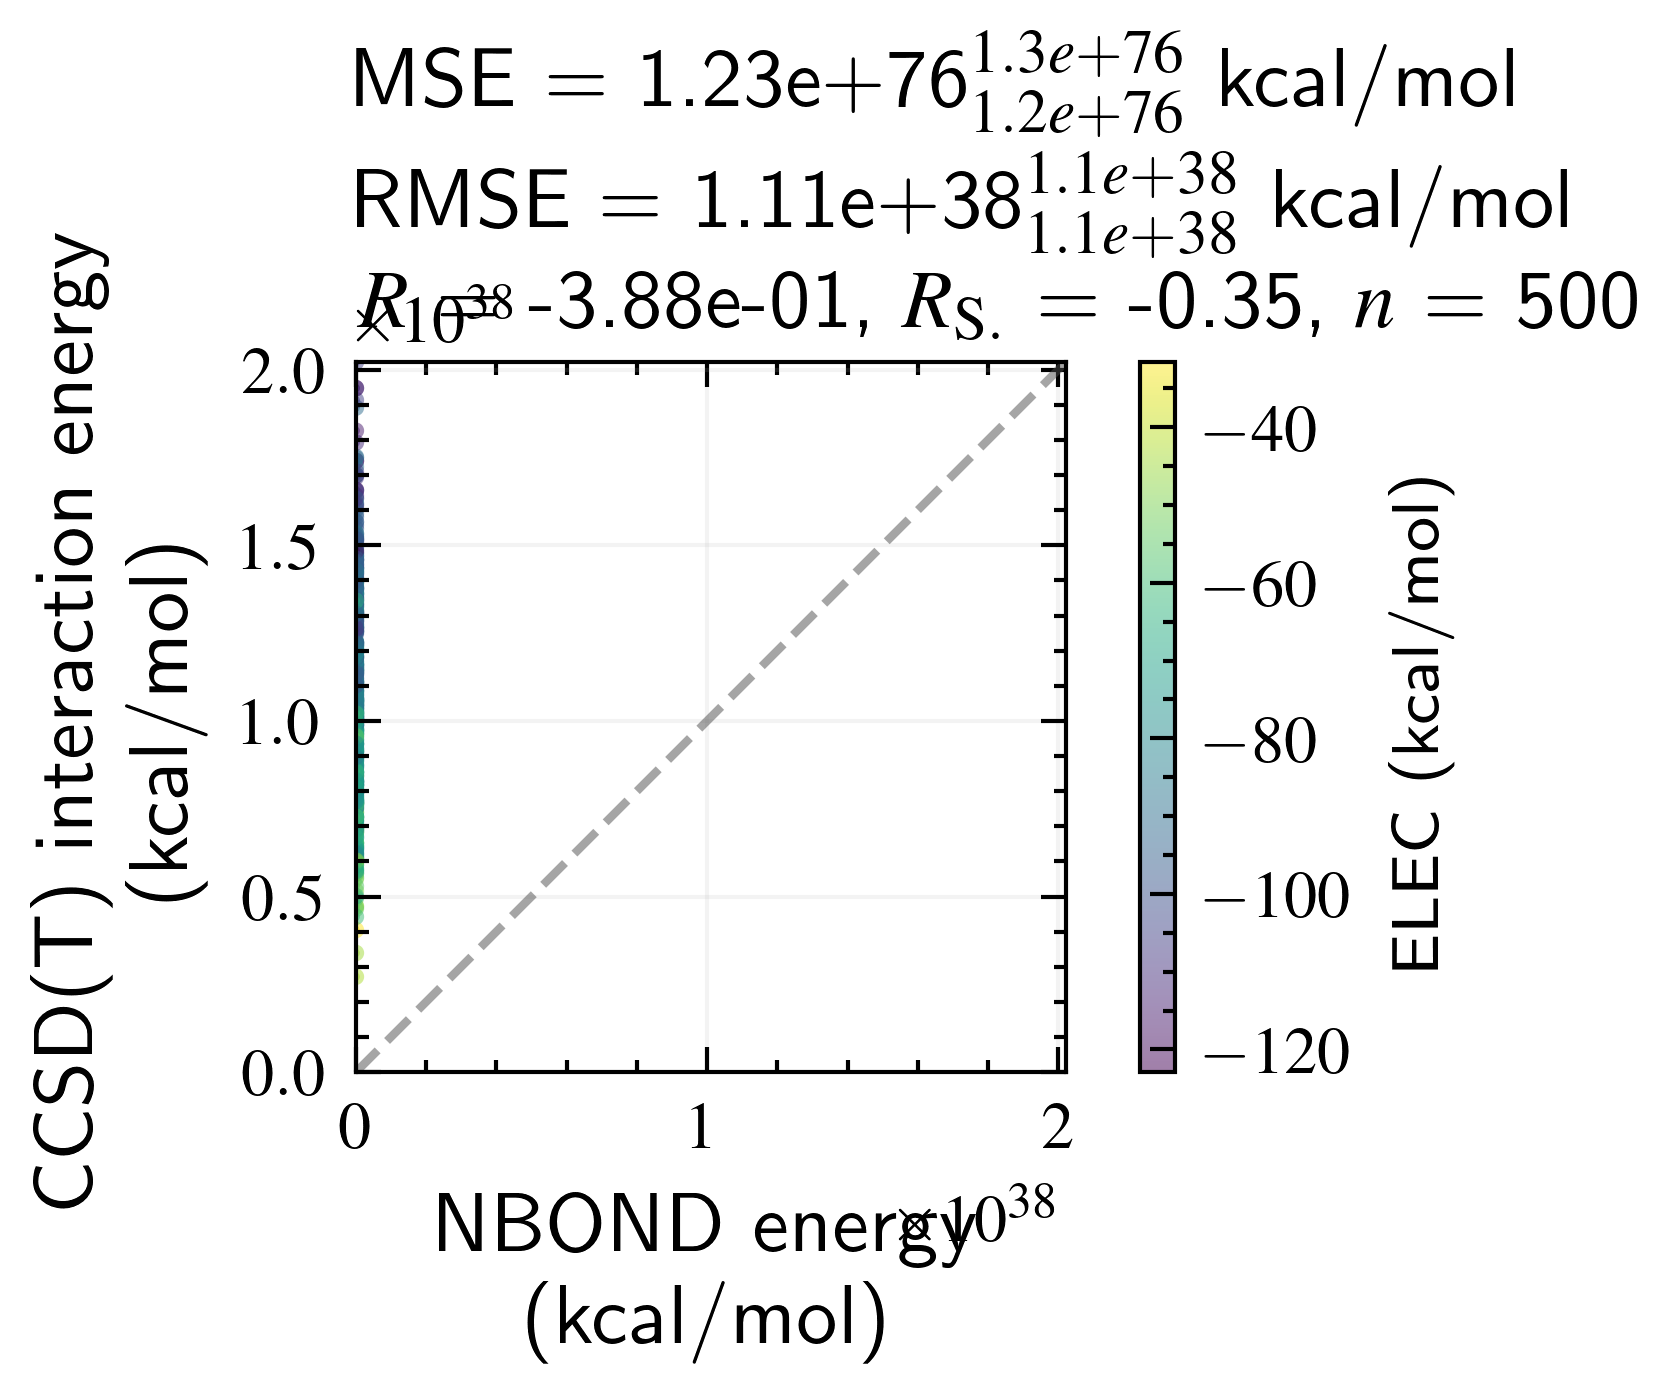

In [63]:
LJFF.data["fit_intE"] = LJFF.eval_jax(resx) + LJFF.data.ELEC

plot_energy_MSE(DEFF.data, "intE", "fit_intE",  elec = "ELEC")



In [27]:
resx = list(pd.DataFrame(\
                  DEFF.opt_results)\
     .sort_values("fun").x)[0]

(array([  7.,  27.,  43.,  79., 100., 111.,  64.,  50.,  13.,   6.]),
 array([-77.66558075, -72.58831787, -67.51104736, -62.43378067,
        -57.35651779, -52.2792511 , -47.20198441, -42.12471771,
        -37.04745102, -31.97018623, -26.89291954]),
 <BarContainer object of 10 artists>)

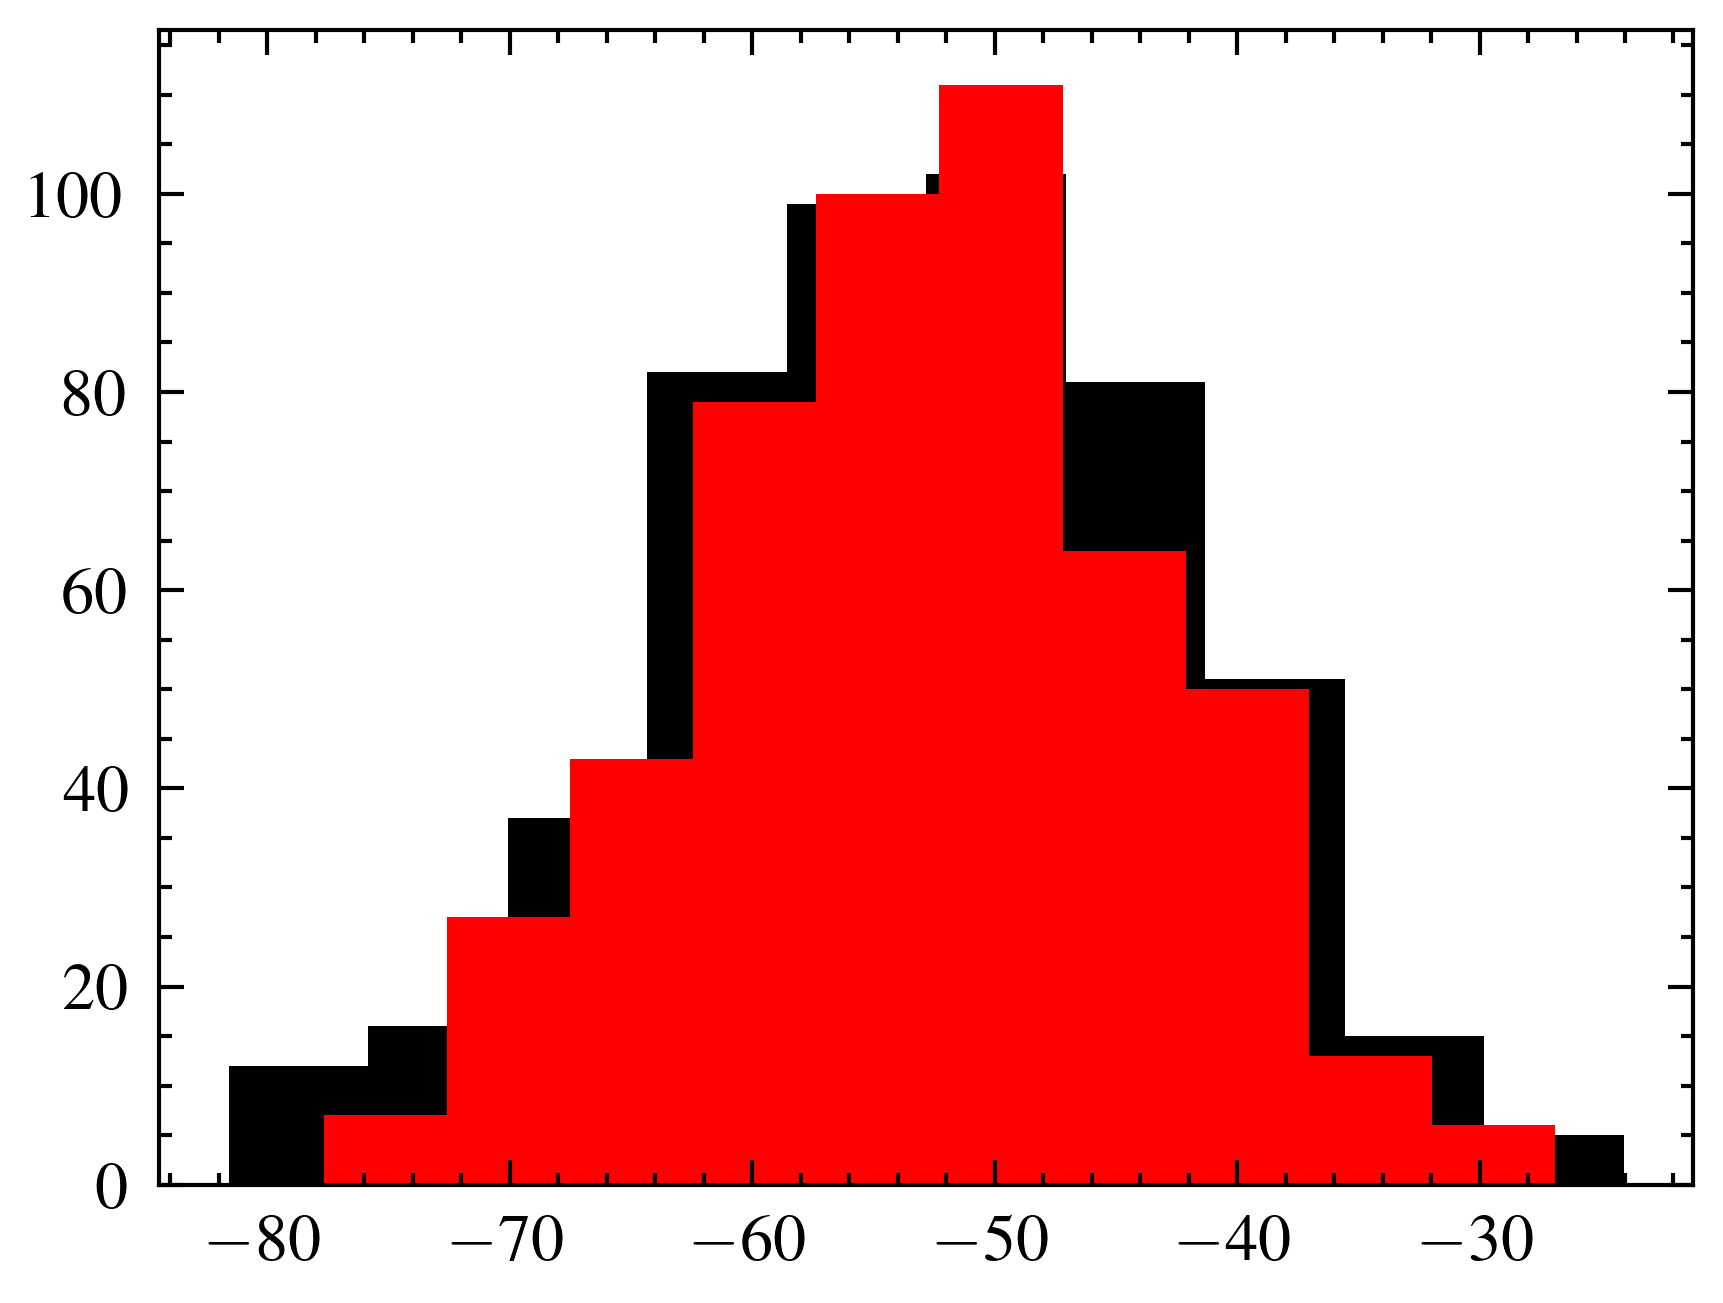

In [32]:
plt.hist(DEFF.targets)
plt.hist(DEFF.eval_jax_de(resx))

In [30]:
resx

array([ 0.34116161,  1.28335808,  2.5       ,  2.49999817,  7.37977031,
       19.28580408])

0.0


(<Axes: xlabel='NBOND energy\n(kcal/mol)', ylabel='CCSD(T) interaction energy\n(kcal/mol)'>,
 {'MSE': 11.775170940231728,
  'RMSE': 3.431496894976262,
  'R': 0.9907021031578068,
  'RS': 0.9895893343573374,
  'n': 500,
  'slope': 0.9575077841699374,
  'intercept': -5.660148647068695})

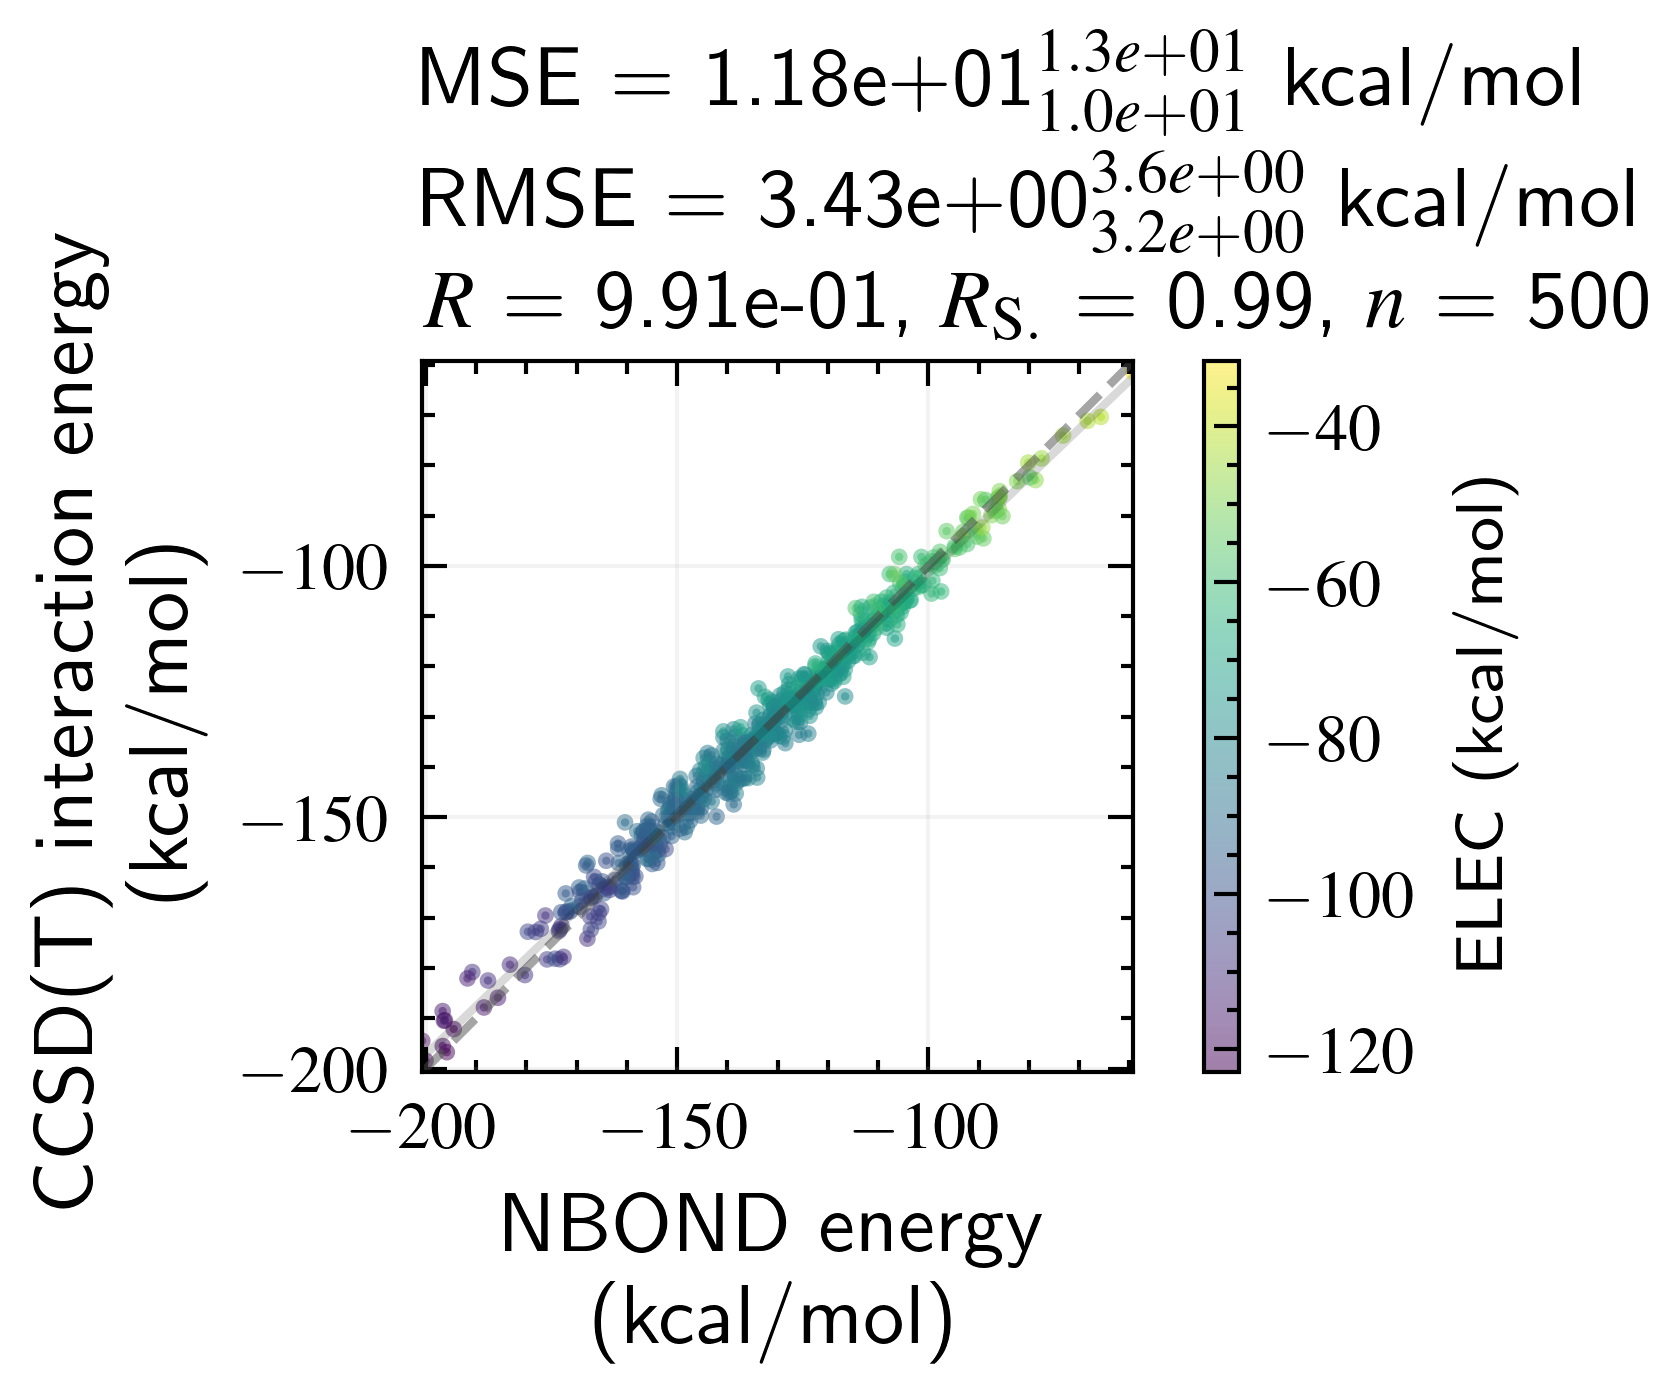

In [31]:
DEFF.data["fit_ECOL_"] = DEFF.eval_jax_de(resx) + _c.data.ELEC

plot_energy_MSE(DEFF.data, "ECOL", "fit_ECOL_",  elec = "ELEC")

